**1**

In [ ]:
# ==========================================
# CELLULE 1 : MONTAGE GOOGLE DRIVE
# ==========================================

from google.colab import drive
import os

print("="*70)
print("💾 MONTAGE GOOGLE DRIVE")
print("="*70)

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
    print("✅ Google Drive monté")
else:
    print("✅ Google Drive déjà monté")

print("="*70)

💾 MONTAGE GOOGLE DRIVE
Mounted at /content/drive
✅ Google Drive monté


**2**

In [ ]:
# ==========================================
# CELLULE 2 : INSTALLATION BARF
# ==========================================

import os
import sys

print("="*70)
print("🔧 INSTALLATION DE L'ENVIRONNEMENT BARF")
print("="*70)

# 1. Créer workspace et cloner BARF
WORKSPACE = '/content/barf_workspace'
BARF_DIR = os.path.join(WORKSPACE, 'bundle-adjusting-NeRF')

os.makedirs(WORKSPACE, exist_ok=True)

if not os.path.exists(BARF_DIR):
    print("\n📥 Clonage du dépôt BARF...")
    os.chdir(WORKSPACE)
    !git clone https://github.com/chenhsuanlin/bundle-adjusting-NeRF.git
    print("✅ Dépôt cloné")
else:
    print("✅ Dépôt BARF déjà présent")

os.chdir(BARF_DIR)
print(f"📂 Répertoire : {os.getcwd()}")

# 2. Installer les dépendances
print("\n📦 Installation des dépendances...")
!pip install -q numpy matplotlib pillow tqdm tensorboard easydict pyyaml opencv-python lpips

# 3. Créer le module SSIM manquant
print("\n🔧 Configuration module SSIM...")
os.makedirs('external', exist_ok=True)

ssim_code = '''"""SSIM implementation"""
import torch
import torch.nn.functional as F
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def pytorch_ssim(img1, img2, window_size=11, size_average=True):
    channel = img1.size()[1]
    window = create_window(window_size, channel)
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding=window_size//2, groups=channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2
    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)
'''

with open('external/pohsun_ssim.py', 'w') as f:
    f.write(ssim_code)
with open('external/__init__.py', 'w') as f:
    f.write('')

print("✅ Module SSIM créé")

# 4. Patcher options.py pour éviter les input() interactifs
print("\n🔧 Patch de options.py...")

with open('options.py', 'r') as f:
    content = f.read()

# Supprimer les input() interactifs
content = content.replace(
    'override = input("override? (y/n) ")',
    'override = "y"  # Auto-patched for Colab'
)
content = content.replace(
    'retry = input("visdom port ({}) not open, retry? (y/n) ".format(opt.visdom.port))',
    'retry = "n"  # Auto-patched for Colab'
)

with open('options.py', 'w') as f:
    f.write(content)

print("✅ options.py patché")

# 5. Modifier le fichier YAML pour barf_c2f
print("\n📝 Configuration YAML...")

import yaml

yaml_path = 'options/barf_blender.yaml'
with open(yaml_path, 'r') as f:
    config_yaml = yaml.safe_load(f)

config_yaml['barf_c2f'] = [0.1, 0.5]
config_yaml['visdom'] = False

with open(yaml_path, 'w') as f:
    yaml.dump(config_yaml, f, default_flow_style=False)

print("✅ YAML configuré")

print("\n" + "="*70)
print("✅ INSTALLATION TERMINÉE")
print("="*70)

🔧 INSTALLATION DE L'ENVIRONNEMENT BARF

📥 Clonage du dépôt BARF...
Cloning into 'bundle-adjusting-NeRF'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 102 (delta 34), reused 19 (delta 19), pack-reused 46 (from 1)
Receiving objects: 100% (102/102), 191.81 KiB | 880.00 KiB/s, done.
Resolving deltas: 100% (52/52), done.
✅ Dépôt cloné
📂 Répertoire : /content/barf_workspace/bundle-adjusting-NeRF

📦 Installation des dépendances...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.3 MB/s eta 0:00:00

🔧 Configuration module SSIM...
✅ Module SSIM créé

🔧 Patch de options.py...
✅ options.py patché

📝 Configuration YAML...
✅ YAML configuré

✅ INSTALLATION TERMINÉE


**3**

In [ ]:
# ==========================================
# CELLULE 3 : GESTIONNAIRE DE DATASETS
# ==========================================

import os
import glob
import shutil
import zipfile

print("="*70)
print("📦 GESTIONNAIRE DE DATASETS")
print("="*70)

# Détection des datasets dans Google Drive
datasets_info = {
    'synthetic': {
        'names': ['nerf_synthetic.zip'],
        'description': 'Dataset synthétique Blender',
        'found': False,
        'path': None
    }
}

search_paths = [
    '/content/drive/MyDrive/NeRF_Data',
    '/content/drive/MyDrive',
]

# Chercher les datasets
for dataset_type, info in datasets_info.items():
    for search_path in search_paths:
        if os.path.exists(search_path):
            for name_pattern in info['names']:
                matches = glob.glob(os.path.join(search_path, name_pattern))
                if matches:
                    info['found'] = True
                    info['path'] = matches[0]
                    break
        if info['found']:
            break

# Afficher résumé
for dataset_type, info in datasets_info.items():
    status = "✅ TROUVÉ" if info['found'] else "❌ NON TROUVÉ"
    print(f"\n{dataset_type.upper()} : {status}")
    if info['found']:
        size_mb = os.path.getsize(info['path']) / (1024 * 1024)
        print(f"   Taille : {size_mb:.1f} MB")

# Fonction d'extraction
def extract_dataset(zip_path, destination):
    print(f"\n📦 Extraction vers {destination}...")
    os.makedirs(destination, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(destination)
    print("✅ Extraction terminée")
    return destination

# Extraire si demandé
if datasets_info['synthetic']['found']:
    choice = input("\nExtraire le dataset synthétique ? (y/n) : ").strip().lower()
    if choice == 'y':
        extract_dataset(
            datasets_info['synthetic']['path'],
            '/content/data'
        )

print("\n" + "="*70)
print("✅ GESTIONNAIRE PRÊT")
print("="*70)

📦 GESTIONNAIRE DE DATASETS

SYNTHETIC : ✅ TROUVÉ
   Taille : 1208.1 MB

Extraire le dataset synthétique ? (y/n) : y

📦 Extraction vers /content/data...
✅ Extraction terminée

✅ GESTIONNAIRE PRÊT


code d'entrainement avec les checkpoints

🧪 EXPÉRIMENTATION 1 : DATASET LEGO - Système de Checkpoints Automatiques

[Installation] 📦 VÉRIFICATION DES DÉPENDANCES
----------------------------------------------------------------------
✅ ipdb déjà installé

[Configuration] 📁 GOOGLE DRIVE
----------------------------------------------------------------------
Mounted at /content/drive
✅ Dossiers Google Drive créés :
   Checkpoints : /content/drive/MyDrive/projet_nerf_barf/checkpoints
   Résultats   : /content/drive/MyDrive/projet_nerf_barf/results
   Logs        : /content/drive/MyDrive/projet_nerf_barf/logs
✅ Dataset trouvé : /content/data/nerf_synthetic/lego

[Étape 1/6] 📊 ANALYSE DU DATASET
----------------------------------------------------------------------
📐 Configuration :
   Images train : 100
   FOV caméra   : 0.6911 rad

📍 Poses ground truth :
   Étendue X : [-3.940, 3.724]
   Étendue Y : [-3.927, 3.950]
   Étendue Z : [0.510, 4.031]

✅ Visualisation : poses_gt_lego.png


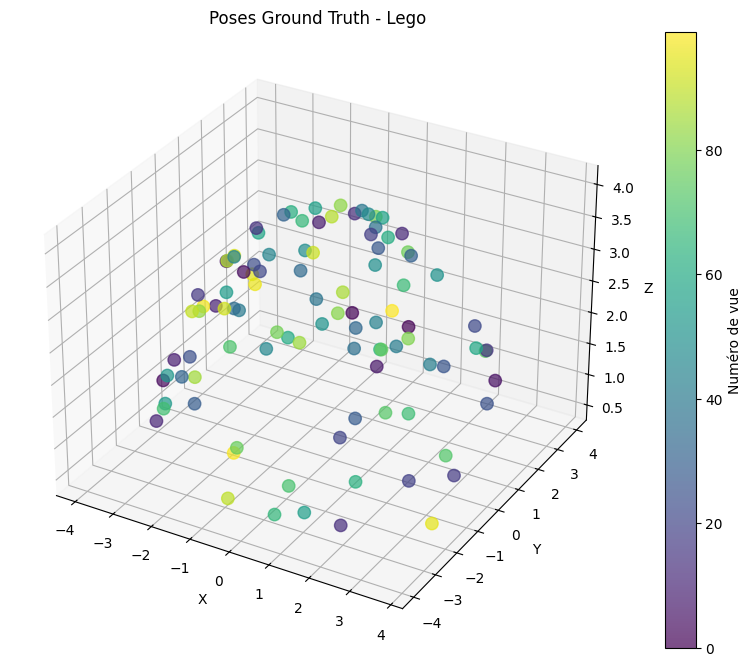


[Étape 2/6] 🔍 VÉRIFICATION CHECKPOINT
----------------------------------------------------------------------
✅ Checkpoint récupéré depuis Google Drive
   Iteration : 100000
   Source : /content/drive/MyDrive/projet_nerf_barf/checkpoints/100000.ckpt

[Étape 3/6] ⚙️ CONFIGURATION BARF
----------------------------------------------------------------------
📊 Configuration choisie :
   Max iterations : 100,000
   Batch size     : 4096
   Checkpoint tous les : 1,000 itérations
   ⏱️ Temps estimé : 25-30 minutes sur GPU T4
   💾 Checkpoints attendus : ~100
   ℹ️ Reprise depuis checkpoint existant

[Étape 4/6] 🚀 ENTRAÎNEMENT
🔧 Lancement de l'entraînement...
🔄 Mode : REPRISE depuis checkpoint

🔍 Surveillance des checkpoints activée (intervalle: 1000 it)
2025-11-30 15:50:40.244424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764517840.264266    50

In [ ]:
# ==========================================
# EXPÉRIMENTATION 1 : DATASET LEGO (AVEC CHECKPOINTS AMÉLIORÉS)
# ==========================================

print("="*70)
print("🧪 EXPÉRIMENTATION 1 : DATASET LEGO - Système de Checkpoints Automatiques")
print("="*70)

import os
import json
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
import subprocess
import sys
import time
import threading
from datetime import datetime

# Variable de contrôle pour l'interruption
TRAINING_INTERRUPTED = False

# ==========================================
# INSTALLATION DES DÉPENDANCES MANQUANTES
# ==========================================
print("\n[Installation] 📦 VÉRIFICATION DES DÉPENDANCES")
print("-"*70)

try:
    import ipdb
    print("✅ ipdb déjà installé")
except ImportError:
    print("⚙️ Installation de ipdb...")
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "ipdb"])
    print("✅ ipdb installé")

missing_packages = []
try:
    import tensorboard
except ImportError:
    missing_packages.append("tensorboard")

try:
    import visdom
except ImportError:
    missing_packages.append("visdom")

if missing_packages:
    print(f"⚙️ Installation de packages supplémentaires: {', '.join(missing_packages)}")
    for pkg in missing_packages:
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg])
    print("✅ Tous les packages installés")

# ==========================================
# CONFIGURATION GOOGLE DRIVE
# ==========================================
print("\n[Configuration] 📁 GOOGLE DRIVE")
print("-"*70)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DRIVE_ROOT = '/content/drive/MyDrive/projet_nerf_barf'
DRIVE_CHECKPOINTS = os.path.join(DRIVE_ROOT, 'checkpoints')
DRIVE_RESULTS = os.path.join(DRIVE_ROOT, 'results')
DRIVE_LOGS = os.path.join(DRIVE_ROOT, 'logs')

os.makedirs(DRIVE_CHECKPOINTS, exist_ok=True)
os.makedirs(DRIVE_RESULTS, exist_ok=True)
os.makedirs(DRIVE_LOGS, exist_ok=True)

print(f"✅ Dossiers Google Drive créés :")
print(f"   Checkpoints : {DRIVE_CHECKPOINTS}")
print(f"   Résultats   : {DRIVE_RESULTS}")
print(f"   Logs        : {DRIVE_LOGS}")

BARF_PATH = '/content/barf_workspace/bundle-adjusting-NeRF'
os.chdir(BARF_PATH)

DATASET_ROOT = '/content/data/nerf_synthetic'
SCENE = 'lego'
SCENE_PATH = os.path.join(DATASET_ROOT, SCENE)

if not os.path.exists(SCENE_PATH):
    print(f"❌ Dataset non trouvé : {SCENE_PATH}")
    raise FileNotFoundError(f"Dataset non trouvé : {SCENE_PATH}")

print(f"✅ Dataset trouvé : {SCENE_PATH}")

# ==========================================
# FONCTIONS UTILITAIRES
# ==========================================

def save_checkpoint_to_drive(checkpoint_path, iteration=None):
    """Sauvegarde un checkpoint vers Google Drive"""
    if os.path.exists(checkpoint_path):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        if iteration:
            filename = f"checkpoint_iter_{iteration}_{timestamp}.ckpt"
        else:
            filename = f"checkpoint_latest_{timestamp}.ckpt"

        dest_path = os.path.join(DRIVE_CHECKPOINTS, filename)

        try:
            shutil.copy2(checkpoint_path, dest_path)
            latest_path = os.path.join(DRIVE_CHECKPOINTS, "checkpoint_latest.ckpt")
            shutil.copy2(checkpoint_path, latest_path)
            print(f"✅ Checkpoint sauvegardé : {filename}")
            return dest_path
        except Exception as e:
            print(f"⚠️ Erreur lors de la sauvegarde du checkpoint : {e}")
            return None
    else:
        print(f"⚠️ Checkpoint non trouvé : {checkpoint_path}")
        return None

def load_checkpoint_from_drive():
    """Charge le dernier checkpoint depuis Google Drive"""
    import glob

    checkpoint_pattern = os.path.join(DRIVE_CHECKPOINTS, "*.ckpt")
    checkpoints = glob.glob(checkpoint_pattern)

    if checkpoints:
        def get_iter_num(path):
            filename = os.path.basename(path)
            try:
                return int(filename.replace('.ckpt', ''))
            except:
                return 0

        latest_checkpoint = max(checkpoints, key=get_iter_num)
        iter_num = get_iter_num(latest_checkpoint)

        local_model_dir = 'output/barf_lego/debug/model'
        os.makedirs(local_model_dir, exist_ok=True)

        local_path = os.path.join(local_model_dir, os.path.basename(latest_checkpoint))
        shutil.copy2(latest_checkpoint, local_path)

        model_ckpt_path = 'output/barf_lego/debug/model.ckpt'
        shutil.copy2(latest_checkpoint, model_ckpt_path)

        print(f"✅ Checkpoint récupéré depuis Google Drive")
        print(f"   Iteration : {iter_num}")
        print(f"   Source : {latest_checkpoint}")
        return True
    else:
        print("ℹ️ Aucun checkpoint trouvé sur Google Drive")
        print("   Démarrage d'un nouvel entraînement")
        return False

def save_results_to_drive():
    """Sauvegarde tous les résultats vers Google Drive"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_dir = os.path.join(DRIVE_RESULTS, f"results_{timestamp}")
    os.makedirs(results_dir, exist_ok=True)

    files_to_save = [
        ('output/barf_lego/debug/results.json', 'results.json'),
        ('output/barf_lego/debug/latest.ckpt', 'final_checkpoint.ckpt'),
        ('poses_gt_lego.png', 'poses_gt_lego.png'),
    ]

    saved_files = []
    for src, dest_name in files_to_save:
        if os.path.exists(src):
            dest = os.path.join(results_dir, dest_name)
            shutil.copy2(src, dest)
            saved_files.append(dest_name)

    vis_dir = 'output/barf_lego/debug/vis'
    if os.path.exists(vis_dir):
        dest_vis_dir = os.path.join(results_dir, 'visualizations')
        shutil.copytree(vis_dir, dest_vis_dir, dirs_exist_ok=True)
        saved_files.append('visualizations/')

    print(f"✅ Résultats sauvegardés dans : {results_dir}")
    for f in saved_files:
        print(f"   - {f}")

    return results_dir

def create_training_log(message, log_type="INFO"):
    """Crée un log d'entraînement"""
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    log_file = os.path.join(DRIVE_LOGS, "training_log.txt")

    with open(log_file, 'a') as f:
        f.write(f"[{timestamp}] [{log_type}] {message}\n")

def monitor_checkpoints(checkpoint_dir, stop_event, checkpoint_interval=1000):
    """Thread qui surveille et sauvegarde automatiquement les checkpoints"""
    checkpoint_path = os.path.join(checkpoint_dir, 'latest.ckpt')
    last_mtime = 0
    last_saved_iteration = 0

    print(f"🔍 Surveillance des checkpoints activée (intervalle: {checkpoint_interval} it)")

    while not stop_event.is_set():
        try:
            if os.path.exists(checkpoint_path):
                current_mtime = os.path.getmtime(checkpoint_path)

                if current_mtime > last_mtime:
                    last_mtime = current_mtime

                    try:
                        import torch
                        checkpoint_data = torch.load(checkpoint_path, map_location='cpu')
                        current_iter = checkpoint_data.get('iter', 0)

                        if current_iter // checkpoint_interval > last_saved_iteration // checkpoint_interval:
                            print(f"\n💾 Sauvegarde automatique du checkpoint (iter {current_iter})...")
                            save_checkpoint_to_drive(checkpoint_path, current_iter)
                            create_training_log(f"Checkpoint auto-sauvegardé - Iteration {current_iter}", "CHECKPOINT")
                            last_saved_iteration = current_iter
                    except Exception as e:
                        print(f"⚠️ Erreur lors de la lecture du checkpoint : {e}")

        except Exception as e:
            print(f"⚠️ Erreur dans le monitoring : {e}")

        time.sleep(30)

# ==========================================
# ÉTAPE 1 : Analyse du Dataset
# ==========================================
print("\n[Étape 1/6] 📊 ANALYSE DU DATASET")
print("-"*70)

with open(os.path.join(SCENE_PATH, 'transforms_train.json'), 'r') as f:
    train_data = json.load(f)

num_train = len(train_data['frames'])
camera_angle_x = train_data.get('camera_angle_x', 0.6911)

print(f"📐 Configuration :")
print(f"   Images train : {num_train}")
print(f"   FOV caméra   : {camera_angle_x:.4f} rad")

poses_gt = np.array([np.array(f['transform_matrix']) for f in train_data['frames']])
positions_gt = poses_gt[:, :3, 3]

print(f"\n📍 Poses ground truth :")
print(f"   Étendue X : [{positions_gt[:, 0].min():.3f}, {positions_gt[:, 0].max():.3f}]")
print(f"   Étendue Y : [{positions_gt[:, 1].min():.3f}, {positions_gt[:, 1].max():.3f}]")
print(f"   Étendue Z : [{positions_gt[:, 2].min():.3f}, {positions_gt[:, 2].max():.3f}]")

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(positions_gt[:, 0], positions_gt[:, 1], positions_gt[:, 2],
                    c=range(len(positions_gt)), cmap='viridis', s=80, alpha=0.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Poses Ground Truth - Lego')
plt.colorbar(scatter, label='Numéro de vue')
plt.savefig('poses_gt_lego.png', dpi=120)
print("\n✅ Visualisation : poses_gt_lego.png")
plt.show()

create_training_log("Analyse du dataset terminée")

# ==========================================
# ÉTAPE 2 : Vérification Checkpoint
# ==========================================
print("\n[Étape 2/6] 🔍 VÉRIFICATION CHECKPOINT")
print("-"*70)

resume_training = load_checkpoint_from_drive()

if resume_training:
    create_training_log("Reprise de l'entraînement depuis checkpoint", "INFO")
else:
    create_training_log("Démarrage d'un nouvel entraînement", "INFO")

# ==========================================
# ÉTAPE 3 : Configuration
# ==========================================
print("\n[Étape 3/6] ⚙️ CONFIGURATION BARF")
print("-"*70)

# PROFIL 2 : ENTRAÎNEMENT STANDARD (recommandé)
MAX_ITER = 100000

CHECKPOINT_FREQ = 1000

config = {
    'group': 'barf_lego',
    'max_iter': MAX_ITER,
    'batch_size': 4096,
    'checkpoint_freq': CHECKPOINT_FREQ,
}

print(f"📊 Configuration choisie :")
print(f"   Max iterations : {MAX_ITER:,}")
print(f"   Batch size     : {config['batch_size']}")
print(f"   Checkpoint tous les : {CHECKPOINT_FREQ:,} itérations")

time_estimates = {
    50000: "10-15 minutes",
    100000: "25-30 minutes",
    150000: "35-40 minutes",
    200000: "45-60 minutes",
}
estimated_time = time_estimates.get(MAX_ITER, "Variable")
print(f"   ⏱️ Temps estimé : {estimated_time} sur GPU T4")

num_checkpoints = MAX_ITER // CHECKPOINT_FREQ
print(f"   💾 Checkpoints attendus : ~{num_checkpoints}")

if resume_training:
    print(f"   ℹ️ Reprise depuis checkpoint existant")

# ==========================================
# ÉTAPE 4 : Entraînement avec Checkpoints
# ==========================================
print("\n[Étape 4/6] 🚀 ENTRAÎNEMENT")
print("="*70)

cmd = [
    "python", "train.py",
    "--group=barf_lego",
    "--model=barf",
    "--yaml=barf_blender",
    "--data.scene=lego",
    f"--data.root={DATASET_ROOT}",
    f"--max_iter={MAX_ITER}",
    "--batch_size=4096",
    "--optim.lr=0.0005",
    "--optim.lr_pose=0.001",
    "--freq.scalar=200",
    "--freq.vis=2000",
    "--freq.val=5000",
    f"--freq.ckpt={CHECKPOINT_FREQ}",
    "--data.num_workers=2"
]

if resume_training:
    cmd.append("--resume")

print("🔧 Lancement de l'entraînement...")
if resume_training:
    print("🔄 Mode : REPRISE depuis checkpoint")
else:
    print("🆕 Mode : NOUVEL entraînement")
print("="*70 + "\n")

stop_monitoring = threading.Event()
checkpoint_dir = 'output/barf_lego/debug'
monitor_thread = threading.Thread(
    target=monitor_checkpoints,
    args=(checkpoint_dir, stop_monitoring, CHECKPOINT_FREQ),
    daemon=True
)
monitor_thread.start()

process = None

try:
    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT,
                              text=True, bufsize=1)

    for line in process.stdout:
        print(line, end='')

    process.wait()

    stop_monitoring.set()
    monitor_thread.join(timeout=5)

    print("\n💾 Sauvegarde finale du checkpoint...")
    final_checkpoint = os.path.join(checkpoint_dir, 'latest.ckpt')
    save_checkpoint_to_drive(final_checkpoint)

    if process.returncode == 0:
        print("\n" + "="*70)
        print("✅ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS")
        print("="*70)
        create_training_log("Entraînement terminé avec succès", "SUCCESS")
    else:
        print(f"\n⚠️ Code retour : {process.returncode}")
        create_training_log(f"Entraînement terminé avec code {process.returncode}", "WARNING")

except KeyboardInterrupt:
    print("\n" + "="*70)
    print("⚠️ ENTRAÎNEMENT INTERROMPU PAR L'UTILISATEUR")
    print("="*70)
    print("💾 Sauvegarde du checkpoint en cours...")

    TRAINING_INTERRUPTED = True
    stop_monitoring.set()

    if process is not None:
        try:
            process.terminate()
            process.wait(timeout=10)
        except:
            try:
                process.kill()
            except:
                pass

    current_checkpoint = os.path.join(checkpoint_dir, 'latest.ckpt')
    if os.path.exists(current_checkpoint):
        save_checkpoint_to_drive(current_checkpoint)
        print("✅ Checkpoint d'interruption sauvegardé")
        create_training_log("Entraînement interrompu - Checkpoint sauvegardé", "INTERRUPT")
    else:
        print("⚠️ Aucun checkpoint trouvé à sauvegarder")

    print("\n💡 Pour reprendre l'entraînement, relancez ce script !")
    print("="*70)

except Exception as e:
    print(f"\n❌ Erreur : {e}")
    TRAINING_INTERRUPTED = True
    stop_monitoring.set()
    create_training_log(f"Erreur : {e}", "ERROR")

# ==========================================
# ÉTAPE 5 : Évaluation (si non interrompu)
# ==========================================
if not TRAINING_INTERRUPTED:
    print("\n[Étape 5/6] 📈 ÉVALUATION")
    print("-"*70)

    eval_cmd = [
        "python", "evaluate.py",
        "--group=barf_lego",
        "--model=barf",
        "--yaml=barf_blender",
        "--data.scene=lego",
        f"--data.root={DATASET_ROOT}",
        "--resume"
    ]

    print("🧪 Évaluation sur le test set...")
    subprocess.run(eval_cmd)

    results_file = 'output/barf_lego/debug/results.json'
    if os.path.exists(results_file):
        with open(results_file, 'r') as f:
            results = json.load(f)

        print("\n📊 RÉSULTATS QUANTITATIFS :")
        print("-"*70)
        psnr = results.get('psnr', 0)
        ssim = results.get('ssim', 0)
        lpips = results.get('lpips', 0)

        print(f"   PSNR  : {psnr:.2f} dB")
        print(f"   SSIM  : {ssim:.4f}")
        print(f"   LPIPS : {lpips:.4f}")
        print("-"*70)

        create_training_log(f"PSNR: {psnr:.2f}, SSIM: {ssim:.4f}, LPIPS: {lpips:.4f}", "RESULTS")

        if psnr > 30:
            print("   🎉 EXCELLENT ! Reconstruction de haute qualité")
        elif psnr > 28:
            print("   ✅ BON ! Résultats satisfaisants")
        else:
            print("   ⚠️ Résultats moyens")
    else:
        print("⚠️ Fichier de résultats non trouvé")

    # ==========================================
    # ÉTAPE 6 : Sauvegarde Finale
    # ==========================================
    print("\n[Étape 6/6] 💾 SAUVEGARDE FINALE")
    print("-"*70)

    results_dir = save_results_to_drive()

    summary_file = os.path.join(results_dir, "summary.txt")
    with open(summary_file, 'w') as f:
        f.write("="*70 + "\n")
        f.write("RÉSUMÉ DE L'EXPÉRIMENTATION - LEGO\n")
        f.write("="*70 + "\n\n")
        f.write(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Dataset : {SCENE}\n")
        f.write(f"Itérations : {MAX_ITER:,}\n")
        f.write(f"Temps estimé : {estimated_time}\n\n")

        if os.path.exists(results_file):
            f.write("MÉTRIQUES :\n")
            f.write(f"  PSNR  : {psnr:.2f} dB\n")
            f.write(f"  SSIM  : {ssim:.4f}\n")
            f.write(f"  LPIPS : {lpips:.4f}\n\n")

        f.write("FICHIERS SAUVEGARDÉS :\n")
        f.write(f"  - Checkpoint final\n")
        f.write(f"  - Résultats JSON\n")
        f.write(f"  - Visualisations\n")
        f.write(f"  - Poses ground truth\n")

    print(f"✅ Résumé créé : summary.txt")

    print("\n" + "="*70)
    print("🎉 EXPÉRIMENTATION TERMINÉE AVEC SUCCÈS")
    print("="*70)
    print(f"\n📁 TOUS LES FICHIERS SONT SAUVEGARDÉS :")
    print(f"   Résultats  : {results_dir}")
    print(f"   Checkpoints: {DRIVE_CHECKPOINTS}")
    print(f"   Logs       : {DRIVE_LOGS}")
    print("\n💡 Pour reprendre l'entraînement, relancez simplement ce script !")
    print("="*70)

    create_training_log("Expérimentation terminée - Tous les fichiers sauvegardés", "COMPLETE")

else:
    # Message de fin en cas d'interruption
    print("\n" + "="*70)
    print("📋 RÉCAPITULATIF APRÈS INTERRUPTION")
    print("="*70)
    print(f"   Checkpoints sauvegardés : {DRIVE_CHECKPOINTS}")
    print(f"   Logs : {DRIVE_LOGS}")
    print("\n💡 Pour reprendre l'entraînement, relancez simplement ce script !")
    print("   Le script détectera automatiquement le dernier checkpoint.")
    print("="*70)

# Avant de lancer l'entrainement il faut dabord lancer les deux scriptes ci dessous

In [ ]:
%%writefile /content/monitor_checkpoints.py
import time
import shutil
import os

LOCAL_CHECKPOINTS = 'output/barf_lego/debug/model'
DRIVE_CHECKPOINTS = '/content/drive/MyDrive/projet_nerf_barf/checkpoints'
saved_files = set()

print("🔄 Surveillance automatique des checkpoints démarrée")

while True:
    if os.path.exists(LOCAL_CHECKPOINTS):
        current_files = set(os.listdir(LOCAL_CHECKPOINTS))
        new_files = current_files - saved_files

        for f in new_files:
            src = os.path.join(LOCAL_CHECKPOINTS, f)
            dst = os.path.join(DRIVE_CHECKPOINTS, f)
            shutil.copy2(src, dst)
            print(f"💾 Sauvegardé : {f}")
            saved_files.add(f)

    time.sleep(60)

Writing /content/monitor_checkpoints.py


In [ ]:
# Lancer en arrière-plan
import subprocess
process = subprocess.Popen(['python', '/content/monitor_checkpoints.py'])
print(f"✅ Monitoring lancé (PID: {process.pid})")

✅ Monitoring lancé (PID: 1052)


In [ ]:
# Exécutez ce code pour explorer ce qui a été créé
import os
import glob

print("🔍 Recherche de tous les fichiers créés...\n")

# Chercher tous les .ckpt
checkpoints = glob.glob("/content/**/*.ckpt", recursive=True)
print(f"📦 Checkpoints trouvés ({len(checkpoints)}):")
for ckpt in checkpoints:
    size = os.path.getsize(ckpt) / (1024*1024)  # MB
    print(f"   {ckpt} ({size:.1f} MB)")

print("\n" + "="*70)

# Chercher tous les fichiers dans output/
if os.path.exists("output"):
    print("\n📁 Contenu de output/:")
    for root, dirs, files in os.walk("output"):
        level = root.replace("output", "").count(os.sep)
        indent = "   " * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = "   " * (level + 1)
        for file in files:
            filepath = os.path.join(root, file)
            size = os.path.getsize(filepath) / (1024*1024)
            print(f"{subindent}{file} ({size:.1f} MB)")

# Chercher results.json
results_files = glob.glob("/content/**/results.json", recursive=True)
print(f"\n📊 Fichiers results.json trouvés ({len(results_files)}):")
for f in results_files:
    print(f"   {f}")

🔍 Recherche de tous les fichiers créés...

📦 Checkpoints trouvés (204):
   /content/drive/MyDrive/projet_nerf_barf (1)/checkpoints/20000.ckpt (6.1 MB)
   /content/drive/MyDrive/projet_nerf_barf (1)/checkpoints/21000.ckpt (6.1 MB)
   /content/drive/MyDrive/projet_nerf_barf (1)/checkpoints/22000.ckpt (6.1 MB)
   /content/drive/MyDrive/projet_nerf_barf (1)/checkpoints/23000.ckpt (6.1 MB)
   /content/drive/MyDrive/projet_nerf_barf (1)/checkpoints/24000.ckpt (6.1 MB)
   /content/drive/MyDrive/projet_nerf_barf (1)/checkpoints/25000.ckpt (6.1 MB)
   /content/drive/MyDrive/projet_nerf_barf (1)/checkpoints/26000.ckpt (6.1 MB)
   /content/drive/MyDrive/projet_nerf_barf (1)/checkpoints/27000.ckpt (6.1 MB)
   /content/drive/MyDrive/projet_nerf_barf (1)/checkpoints/28000.ckpt (6.1 MB)
   /content/drive/MyDrive/projet_nerf_barf (1)/checkpoints/29000.ckpt (6.1 MB)
   /content/drive/MyDrive/projet_nerf_barf (1)/checkpoints/30000.ckpt (6.1 MB)
   /content/drive/MyDrive/projet_nerf_barf (1)/checkpoints/

In [ ]:
CHECKPOINT_PATH = "/content/drive/MyDrive/projet_nerf_barf/checkpoints/20000.ckpt"
OUTPUT_DIR = "/content/barf_workspace/bundle-adjusting-NeRF/output/barf_lego/debug"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [ ]:


# 2. Exécuter l'évaluation
!python /content/barf_workspace/bundle-adjusting-NeRF/evaluate.py \
    --group=barf_lego \
    --model=barf \
    --yaml=barf_blender \
    --data.scene=lego \
    --data.root=/content/data/nerf_synthetic \
    --load=/content/drive/MyDrive/projet_nerf_barf/checkpoints/20000.ckpt

Process ID: 4978
[/content/barf_workspace/bundle-adjusting-NeRF/evaluate.py] (PyTorch code for evaluating NeRF/BARF)
setting configurations...
loading options/base.yaml...
loading options/nerf_blender.yaml...
loading options/barf_blender.yaml...
* H: 400
* W: 400
* arch:
   * density_activ: softplus
   * layers_feat: [None, 256, 256, 256, 256, 256, 256, 256, 256]
   * layers_rgb: [None, 128, 3]
   * posenc:
      * L_3D: 10
      * L_view: 4
   * skip: [4]
   * tf_init: True
* barf_c2f: [0.1, 0.5]
* batch_size: None
* camera:
   * model: perspective
   * ndc: False
   * noise: 0.15
* cpu: False
* data:
   * augment:
   * bgcolor: 1
   * center_crop: None
   * dataset: blender
   * image_size: [400, 400]
   * num_workers: 4
   * preload: True
   * root: /content/data/nerf_synthetic
   * scene: lego
   * train_sub: None
   * val_on_test: False
   * val_sub: 4
* device: cuda:0
* freq:
   * ckpt: 5000
   * scalar: 200
   * val: 2000
   * vis: 1000
* gpu: 0
* group: barf_lego
* load: /conte

In [ ]:
!pip install ipdb

In [ ]:
!pip install visdom

In [ ]:
# Corriger l'appel SSIM avec gestion adaptative des dimensions
nerf_file = '/content/barf_workspace/bundle-adjusting-NeRF/model/nerf.py'

with open(nerf_file, 'r') as f:
    content = f.read()

# Remplacer par un code qui gère automatiquement les dimensions
old_line = 'ssim = pytorch_ssim(rgb_map.permute(2,0,1).unsqueeze(0), var.image.permute(2,0,1).unsqueeze(0)).item()'

new_code = '''# Adapter les dimensions pour SSIM
            if rgb_map.dim() == 3:  # [H, W, C]
                rgb_ssim = rgb_map.permute(2,0,1).unsqueeze(0)  # -> [1, C, H, W]
            else:  # déjà [1, H, W, C] ou [1, C, H, W]
                if rgb_map.shape[-1] == 3:  # [1, H, W, C]
                    rgb_ssim = rgb_map.permute(0,3,1,2)  # -> [1, C, H, W]
                else:  # déjà [1, C, H, W]
                    rgb_ssim = rgb_map

            if var.image.dim() == 3:  # [H, W, C]
                img_ssim = var.image.permute(2,0,1).unsqueeze(0)  # -> [1, C, H, W]
            else:  # déjà [1, H, W, C] ou [1, C, H, W]
                if var.image.shape[-1] == 3:  # [1, H, W, C]
                    img_ssim = var.image.permute(0,3,1,2)  # -> [1, C, H, W]
                else:  # déjà [1, C, H, W]
                    img_ssim = var.image

            ssim = pytorch_ssim(rgb_ssim, img_ssim).item()'''

content = content.replace(old_line, new_code)

with open(nerf_file, 'w') as f:
    f.write(content)

print("✅ Code SSIM adaptatif ajouté")

✅ Code SSIM adaptatif ajouté


In [ ]:
# Chercher tous les dossiers "output"
!find /content -type d -name "output" 2>/dev/null

# Chercher les fichiers vidéo récemment créés
!find /content -type f -name "*.mp4" -o -name "*.gif" -o -name "*.png" | head -20

# Vérifier le dossier de travail actuel
!pwd

# Lister les fichiers dans le répertoire BARF
!ls -la /content/barf_workspace/bundle-adjusting-NeRF/

/content/barf_workspace/bundle-adjusting-NeRF/output
/content/drive/MyDrive/projet_nerf_barf/results/results_20251122_095039/poses_gt_lego.png
/content/drive/MyDrive/projet_nerf_barf/results/results_20251122_122911/poses_gt_lego.png
/content/drive/MyDrive/projet_nerf_barf/results/results_20251123_151212/poses_gt_lego.png
/content/drive/MyDrive/projet_nerf_barf/results/results_20251123_153909/poses_gt_lego.png
/content/drive/MyDrive/projet_nerf_barf/results/results_20251123_154842/poses_gt_lego.png
/content/drive/MyDrive/projet_nerf_barf/results/results_20251123_155523/poses_gt_lego.png
/content/drive/MyDrive/projet_nerf_barf/results/results_20251123_155759/poses_gt_lego.png
/content/drive/MyDrive/projet_nerf_barf/results/results_20251123_160014/poses_gt_lego.png
/content/drive/MyDrive/projet_nerf_barf/results/results_20251123_160040/poses_gt_lego.png
/content/drive/MyDrive/projet_nerf_barf/results/results_20251123_160151/poses_gt_lego.png
/content/drive/MyDrive/projet_nerf_barf/results

In [ ]:
# Voir la structure complète du dossier output
!ls -lhR /content/barf_workspace/bundle-adjusting-NeRF/output/

# Ou plus spécifiquement pour votre groupe barf_lego
!ls -lh /content/barf_workspace/bundle-adjusting-NeRF/output/barf_lego/

# Si le dossier debug existe
!ls -lh /content/barf_workspace/bundle-adjusting-NeRF/output/barf_lego/debug/ 2>/dev/null || echo "Pas de dossier debug"

/content/barf_workspace/bundle-adjusting-NeRF/output/:
total 4.0K
drwxr-xr-x 3 root root 4.0K Nov 28 12:26 barf_lego

/content/barf_workspace/bundle-adjusting-NeRF/output/barf_lego:
total 4.0K
drwxr-xr-x 8 root root 4.0K Nov 28 14:21 debug

/content/barf_workspace/bundle-adjusting-NeRF/output/barf_lego/debug:
total 13M
drwxr-xr-x 2 root root 4.0K Nov 28 14:21 20000
drwxr-xr-x 2 root root 4.0K Nov 28 14:21 21000
drwxr-xr-x 2 root root 4.0K Nov 28 14:21 22000
drwxr-xr-x 2 root root 4.0K Nov 28 14:21 checkpoint_latest
-rw-r--r-- 1 root root 682K Nov 28 12:30 events.out.tfevents.1764332859.b031689cdc94.3544.0
-rw------- 1 root root 6.1M Nov 28 13:12 latest.ckpt
-rw------- 1 root root 6.1M Nov 28 13:12 model.ckpt
-rw-r--r-- 1 root root 1.7K Nov 28 12:27 options.yaml
drwxr-xr-x 2 root root 4.0K Nov 28 15:02 poses
-rw-r--r-- 1 root root  50K Nov 28 15:02 poses.mp4
-rw-r--r-- 1 root root 4.4K Nov 28 15:02 quant_pose.txt
-rw-r--r-- 1 root root  181 Nov 28 15:04 quant.txt
drwxr-xr-x 2 root root 

**4**                                     hadi pour tout les checkpoints li kayn


In [ ]:
# ==========================================
# ÉVALUATION AUTOMATIQUE DE TOUS LES CHECKPOINTS
# ==========================================

import os
import glob
from datetime import datetime
import subprocess
import re

# Paramètres
checkpoint_dir = "/content/drive/MyDrive/projet_nerf_barf/checkpoints"
results_base_dir = "/content/drive/MyDrive/projet_nerf_barf/results"
barf_dir = "/content/barf_workspace/bundle-adjusting-NeRF"
data_root = "/content/data/nerf_synthetic"

# Créer le dossier de résultats
os.makedirs(results_base_dir, exist_ok=True)

# Trouver tous les checkpoints
checkpoint_files = sorted(glob.glob(os.path.join(checkpoint_dir, "*.ckpt")))

print(f"🔍 Checkpoints trouvés : {len(checkpoint_files)}")
for ckpt in checkpoint_files:
    print(f"  - {os.path.basename(ckpt)}")

if len(checkpoint_files) == 0:
    print("❌ Aucun checkpoint trouvé!")
    exit(1)

print("\n" + "="*70)
print("🚀 DÉBUT DE L'ÉVALUATION")
print("="*70 + "\n")

# Résultats globaux
results_summary = []

# Évaluer chaque checkpoint
for idx, checkpoint_path in enumerate(checkpoint_files, 1):
    checkpoint_name = os.path.basename(checkpoint_path).replace('.ckpt', '')

    print(f"\n{'='*70}")
    print(f"📊 [{idx}/{len(checkpoint_files)}] Évaluation : {checkpoint_name}")
    print(f"{'='*70}\n")

    # Créer un dossier de résultats pour ce checkpoint
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    result_dir = os.path.join(results_base_dir, f"eval_{checkpoint_name}")
    os.makedirs(result_dir, exist_ok=True)

    try:
        # Nettoyer les anciens résultats BARF
        output_barf = f"{barf_dir}/output/barf_lego"
        if os.path.exists(output_barf):
            os.system(f"rm -rf {output_barf}")

        # Commande d'évaluation
        cmd = [
            "python", f"{barf_dir}/evaluate.py",
            "--group=barf_lego",
            "--model=barf",
            "--yaml=barf_blender",
            "--data.scene=lego",
            f"--data.root={data_root}",
            f"--load={checkpoint_path}"
        ]

        print(f"🔄 Exécution de l'évaluation...")

        # Exécuter l'évaluation
        result = subprocess.run(
            cmd,
            cwd=barf_dir,
            capture_output=True,
            text=True,
            timeout=600  # Timeout de 10 minutes
        )

        # Sauvegarder les logs
        log_file = os.path.join(result_dir, "evaluation_log.txt")
        with open(log_file, 'w') as f:
            f.write(f"Checkpoint: {checkpoint_name}\n")
            f.write(f"Path: {checkpoint_path}\n")
            f.write(f"Date: {datetime.now()}\n\n")
            f.write("="*70 + "\n")
            f.write("STDOUT:\n")
            f.write("="*70 + "\n")
            f.write(result.stdout)
            f.write("\n\n" + "="*70 + "\n")
            f.write("STDERR:\n")
            f.write("="*70 + "\n")
            f.write(result.stderr)

        # Extraire les métriques PSNR, SSIM, LPIPS
        output = result.stdout + result.stderr
        psnr = ssim = lpips = "N/A"
        rot_error = trans_error = "N/A"

        # Rechercher les métriques
        for line in output.split('\n'):
            if 'PSNR:' in line:
                match = re.search(r'PSNR:\s+([\d.]+)', line)
                if match:
                    psnr = match.group(1)
            if 'SSIM:' in line:
                match = re.search(r'SSIM:\s+([\d.]+)', line)
                if match:
                    ssim = match.group(1)
            if 'LPIPS:' in line:
                match = re.search(r'LPIPS:\s+([\d.]+)', line)
                if match:
                    lpips = match.group(1)
            if 'rot:' in line:
                match = re.search(r'rot:\s+([\d.]+)', line)
                if match:
                    rot_error = match.group(1)
            if 'trans:' in line:
                match = re.search(r'trans:\s+([\d.]+)', line)
                if match:
                    trans_error = match.group(1)

        # Copier les résultats générés
        if os.path.exists(output_barf):
            print(f"📁 Copie des résultats...")
            os.system(f"cp -r {output_barf}/* {result_dir}/ 2>/dev/null")
            print(f"✅ Résultats sauvegardés dans : {result_dir}")

        # Enregistrer les résultats
        status = 'SUCCESS' if result.returncode == 0 else 'FAILED'
        results_summary.append({
            'checkpoint': checkpoint_name,
            'psnr': psnr,
            'ssim': ssim,
            'lpips': lpips,
            'rot_error': rot_error,
            'trans_error': trans_error,
            'result_dir': result_dir,
            'status': status
        })

        print(f"\n📈 Métriques pour {checkpoint_name}:")
        print(f"   PSNR:       {psnr}")
        print(f"   SSIM:       {ssim}")
        print(f"   LPIPS:      {lpips}")
        print(f"   Rot Error:  {rot_error}°")
        print(f"   Trans Err:  {trans_error}")
        print(f"   Status:     {status}")

    except subprocess.TimeoutExpired:
        print(f"⏱️ Timeout lors de l'évaluation de {checkpoint_name}")
        results_summary.append({
            'checkpoint': checkpoint_name,
            'psnr': 'TIMEOUT',
            'ssim': 'TIMEOUT',
            'lpips': 'TIMEOUT',
            'rot_error': 'TIMEOUT',
            'trans_error': 'TIMEOUT',
            'result_dir': result_dir,
            'status': 'TIMEOUT'
        })
    except Exception as e:
        print(f"❌ Erreur lors de l'évaluation de {checkpoint_name}: {str(e)}")
        results_summary.append({
            'checkpoint': checkpoint_name,
            'psnr': 'ERROR',
            'ssim': 'ERROR',
            'lpips': 'ERROR',
            'rot_error': 'ERROR',
            'trans_error': 'ERROR',
            'result_dir': result_dir,
            'status': 'ERROR'
        })

# Créer un rapport récapitulatif
print("\n" + "="*70)
print("📋 RÉSUMÉ DES ÉVALUATIONS")
print("="*70 + "\n")

summary_file = os.path.join(results_base_dir, f"evaluation_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt")

with open(summary_file, 'w') as f:
    # En-tête
    f.write("="*70 + "\n")
    f.write("RAPPORT D'ÉVALUATION BARF - SCÈNE LEGO\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("="*70 + "\n\n")

    # Tableau des résultats
    header = f"{'Checkpoint':<15} {'PSNR':<8} {'SSIM':<8} {'LPIPS':<8} {'Rot°':<8} {'Trans':<8} {'Status':<10}"
    separator = "-" * len(header)

    print(header)
    print(separator)
    f.write(header + "\n")
    f.write(separator + "\n")

    for res in results_summary:
        line = (f"{res['checkpoint']:<15} {res['psnr']:<8} {res['ssim']:<8} "
                f"{res['lpips']:<8} {res['rot_error']:<8} {res['trans_error']:<8} {res['status']:<10}")
        print(line)
        f.write(line + "\n")

    print(separator)
    f.write(separator + "\n")

    # Statistiques
    successful = [r for r in results_summary if r['status'] == 'SUCCESS']
    if successful:
        f.write(f"\n{'='*70}\n")
        f.write("STATISTIQUES\n")
        f.write(f"{'='*70}\n")
        f.write(f"Total évalués: {len(results_summary)}\n")
        f.write(f"Succès: {len(successful)}\n")
        f.write(f"Échecs: {len(results_summary) - len(successful)}\n")

        # Meilleur checkpoint
        try:
            best_psnr = max(successful, key=lambda x: float(x['psnr']) if x['psnr'] != 'N/A' else 0)
            f.write(f"\nMeilleur PSNR: {best_psnr['checkpoint']} ({best_psnr['psnr']})\n")
            print(f"\n🏆 Meilleur PSNR: {best_psnr['checkpoint']} ({best_psnr['psnr']})")
        except:
            pass

    # Informations supplémentaires
    f.write(f"\n{'='*70}\n")
    f.write(f"Résultats complets sauvegardés dans : {results_base_dir}\n")
    f.write(f"Rapport récapitulatif : {summary_file}\n")
    f.write(f"{'='*70}\n")

print("\n✅ Évaluation terminée pour tous les checkpoints!")
print(f"📁 Consultez les résultats dans : {results_base_dir}")
print(f"📄 Rapport récapitulatif : {summary_file}")

🔍 Checkpoints trouvés : 88
  - 100000.ckpt
  - 20000.ckpt
  - 21000.ckpt
  - 22000.ckpt
  - 23000.ckpt
  - 24000.ckpt
  - 25000.ckpt
  - 26000.ckpt
  - 27000.ckpt
  - 28000.ckpt
  - 29000.ckpt
  - 30000.ckpt
  - 31000.ckpt
  - 32000.ckpt
  - 33000.ckpt
  - 34000.ckpt
  - 35000.ckpt
  - 36000.ckpt
  - 37000.ckpt
  - 38000.ckpt
  - 39000.ckpt
  - 40000.ckpt
  - 41000.ckpt
  - 42000.ckpt
  - 43000.ckpt
  - 44000.ckpt
  - 45000.ckpt
  - 46000.ckpt
  - 47000.ckpt
  - 48000.ckpt
  - 49000.ckpt
  - 50000.ckpt
  - 51000.ckpt
  - 52000.ckpt
  - 53000.ckpt
  - 54000.ckpt
  - 55000.ckpt
  - 56000.ckpt
  - 57000.ckpt
  - 58000.ckpt
  - 59000.ckpt
  - 60000.ckpt
  - 61000.ckpt
  - 62000.ckpt
  - 63000.ckpt
  - 64000.ckpt
  - 65000.ckpt
  - 66000.ckpt
  - 67000.ckpt
  - 68000.ckpt
  - 69000.ckpt
  - 70000.ckpt
  - 71000.ckpt
  - 72000.ckpt
  - 73000.ckpt
  - 74000.ckpt
  - 75000.ckpt
  - 76000.ckpt
  - 77000.ckpt
  - 78000.ckpt
  - 79000.ckpt
  - 80000.ckpt
  - 81000.ckpt
  - 82000.ckpt
  - 83000.ck

KeyboardInterrupt: 

🔍 ÉVALUATION DES CHECKPOINTS AVANT DIVERGENCE
Total checkpoints trouvés: 88
Checkpoints à évaluer (≤20k): 1

Checkpoints sélectionnés:
  ✓ 20000.ckpt (iteration 20000)

Checkpoints ignorés (87):
  ✗ 21000.ckpt
  ✗ 22000.ckpt
  ✗ 23000.ckpt
  ✗ 24000.ckpt
  ✗ 25000.ckpt
  ... et 82 autres

🚀 DÉBUT DE L'ÉVALUATION


📊 [1/1] Évaluation : 20000 (iter 20000)

🔄 Exécution de l'évaluation...
📁 Copie des résultats...
✅ Résultats sauvegardés dans : /content/drive/MyDrive/projet_nerf_barf/results/eval_20000

📈 Métriques pour 20000:
   PSNR:       21.81
   SSIM:       0.80
   LPIPS:      0.23
   Rot Error:  0.396°
   Trans Err:  0.01166
   Status:     SUCCESS

📋 RÉSUMÉ DES ÉVALUATIONS (CHECKPOINTS ≤20k)

Iter     PSNR     SSIM     LPIPS    Rot°     Trans      Status    
------------------------------------------------------------------
20000    21.81    0.80     0.23     0.396    0.01166    SUCCESS   
------------------------------------------------------------------

🏆 Meilleur PSNR: iteration 2

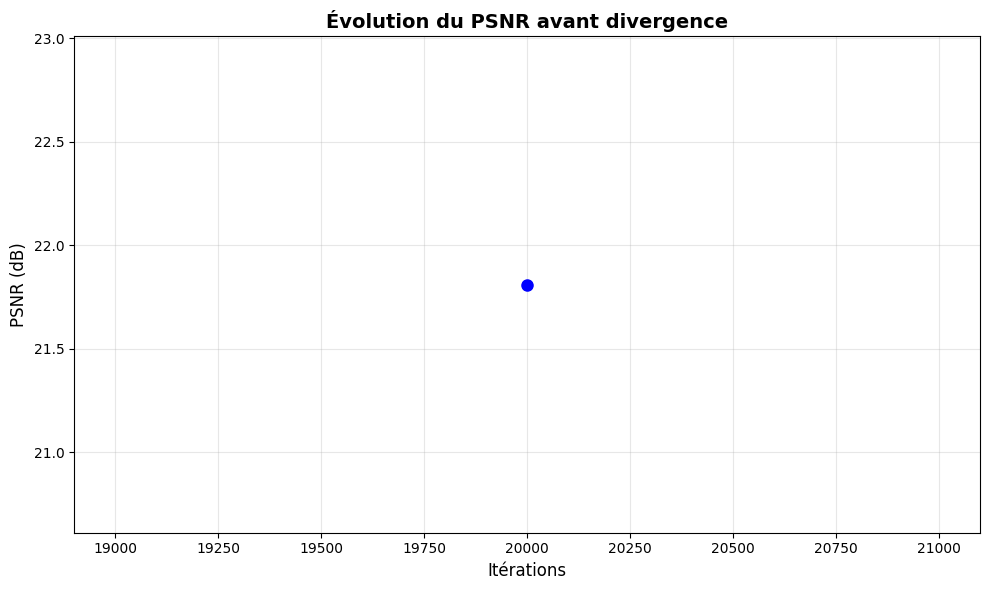

In [ ]:
# ==========================================
# ÉVALUATION DES CHECKPOINTS AVANT DIVERGENCE (≤20000)
# ==========================================

import os
import glob
from datetime import datetime
import subprocess
import re

# Paramètres
checkpoint_dir = "/content/drive/MyDrive/projet_nerf_barf/checkpoints"
results_base_dir = "/content/drive/MyDrive/projet_nerf_barf/results"
barf_dir = "/content/barf_workspace/bundle-adjusting-NeRF"
data_root = "/content/data/nerf_synthetic"

# Créer le dossier de résultats
os.makedirs(results_base_dir, exist_ok=True)

# Fonction pour extraire le numéro d'itération du nom du fichier
def get_iteration_number(filename):
    """Extrait le numéro d'itération du nom de fichier"""
    basename = os.path.basename(filename).replace('.ckpt', '')
    try:
        # Si c'est juste un nombre (ex: "20000.ckpt")
        return int(basename)
    except ValueError:
        # Si c'est un nom spécial comme "checkpoint_latest_..."
        # On ignore ces fichiers
        return None

# Trouver tous les checkpoints
all_checkpoints = glob.glob(os.path.join(checkpoint_dir, "*.ckpt"))

# Filtrer et trier les checkpoints <= 20000
checkpoint_files = []
for f in all_checkpoints:
    iteration = get_iteration_number(f)
    if iteration is not None and iteration <= 20000:
        checkpoint_files.append((f, iteration))

# Trier par numéro d'itération
checkpoint_files.sort(key=lambda x: x[1])
checkpoint_files = [f[0] for f in checkpoint_files]

print("="*70)
print(f"🔍 ÉVALUATION DES CHECKPOINTS AVANT DIVERGENCE")
print("="*70)
print(f"Total checkpoints trouvés: {len(all_checkpoints)}")
print(f"Checkpoints à évaluer (≤20k): {len(checkpoint_files)}")
print("\nCheckpoints sélectionnés:")
for ckpt in checkpoint_files:
    iter_num = get_iteration_number(ckpt)
    print(f"  ✓ {os.path.basename(ckpt)} (iteration {iter_num})")

# Afficher les checkpoints ignorés
ignored = [f for f in all_checkpoints if get_iteration_number(f) is None or get_iteration_number(f) > 20000]
if ignored:
    print(f"\nCheckpoints ignorés ({len(ignored)}):")
    for ckpt in ignored[:5]:  # Afficher seulement les 5 premiers
        print(f"  ✗ {os.path.basename(ckpt)}")
    if len(ignored) > 5:
        print(f"  ... et {len(ignored)-5} autres")

if len(checkpoint_files) == 0:
    print("❌ Aucun checkpoint ≤20000 trouvé!")
    exit(1)

print("\n" + "="*70)
print("🚀 DÉBUT DE L'ÉVALUATION")
print("="*70 + "\n")

# Résultats globaux
results_summary = []

# Évaluer chaque checkpoint
for idx, checkpoint_path in enumerate(checkpoint_files, 1):
    checkpoint_name = os.path.basename(checkpoint_path).replace('.ckpt', '')
    checkpoint_iter = get_iteration_number(checkpoint_path)

    print(f"\n{'='*70}")
    print(f"📊 [{idx}/{len(checkpoint_files)}] Évaluation : {checkpoint_name} (iter {checkpoint_iter})")
    print(f"{'='*70}\n")

    # Créer un dossier de résultats pour ce checkpoint
    result_dir = os.path.join(results_base_dir, f"eval_{checkpoint_name}")
    os.makedirs(result_dir, exist_ok=True)

    try:
        # Nettoyer les anciens résultats BARF
        output_barf = f"{barf_dir}/output/barf_lego"
        if os.path.exists(output_barf):
            os.system(f"rm -rf {output_barf}")

        # Commande d'évaluation
        cmd = [
            "python", f"{barf_dir}/evaluate.py",
            "--group=barf_lego",
            "--model=barf",
            "--yaml=barf_blender",
            "--data.scene=lego",
            f"--data.root={data_root}",
            f"--load={checkpoint_path}"
        ]

        print(f"🔄 Exécution de l'évaluation...")

        # Exécuter l'évaluation
        result = subprocess.run(
            cmd,
            cwd=barf_dir,
            capture_output=True,
            text=True,
            timeout=600  # Timeout de 10 minutes
        )

        # Sauvegarder les logs
        log_file = os.path.join(result_dir, "evaluation_log.txt")
        with open(log_file, 'w') as f:
            f.write(f"Checkpoint: {checkpoint_name}\n")
            f.write(f"Iteration: {checkpoint_iter}\n")
            f.write(f"Path: {checkpoint_path}\n")
            f.write(f"Date: {datetime.now()}\n\n")
            f.write("="*70 + "\n")
            f.write("STDOUT:\n")
            f.write("="*70 + "\n")
            f.write(result.stdout)
            f.write("\n\n" + "="*70 + "\n")
            f.write("STDERR:\n")
            f.write("="*70 + "\n")
            f.write(result.stderr)

        # Extraire les métriques
        output = result.stdout + result.stderr
        psnr = ssim = lpips = "N/A"
        rot_error = trans_error = "N/A"

        for line in output.split('\n'):
            if 'PSNR:' in line:
                match = re.search(r'PSNR:\s+([\d.]+)', line)
                if match:
                    psnr = match.group(1)
            if 'SSIM:' in line:
                match = re.search(r'SSIM:\s+([\d.]+)', line)
                if match:
                    ssim = match.group(1)
            if 'LPIPS:' in line:
                match = re.search(r'LPIPS:\s+([\d.]+)', line)
                if match:
                    lpips = match.group(1)
            if 'rot:' in line:
                match = re.search(r'rot:\s+([\d.]+)', line)
                if match:
                    rot_error = match.group(1)
            if 'trans:' in line:
                match = re.search(r'trans:\s+([\d.]+)', line)
                if match:
                    trans_error = match.group(1)

        # Copier les résultats générés
        if os.path.exists(output_barf):
            print(f"📁 Copie des résultats...")
            os.system(f"cp -r {output_barf}/* {result_dir}/ 2>/dev/null")
            print(f"✅ Résultats sauvegardés dans : {result_dir}")

        # Enregistrer les résultats
        status = 'SUCCESS' if result.returncode == 0 else 'FAILED'
        results_summary.append({
            'checkpoint': checkpoint_name,
            'iteration': checkpoint_iter,
            'psnr': psnr,
            'ssim': ssim,
            'lpips': lpips,
            'rot_error': rot_error,
            'trans_error': trans_error,
            'result_dir': result_dir,
            'status': status
        })

        print(f"\n📈 Métriques pour {checkpoint_name}:")
        print(f"   PSNR:       {psnr}")
        print(f"   SSIM:       {ssim}")
        print(f"   LPIPS:      {lpips}")
        print(f"   Rot Error:  {rot_error}°")
        print(f"   Trans Err:  {trans_error}")
        print(f"   Status:     {status}")

    except subprocess.TimeoutExpired:
        print(f"⏱️ Timeout lors de l'évaluation de {checkpoint_name}")
        results_summary.append({
            'checkpoint': checkpoint_name,
            'iteration': checkpoint_iter,
            'psnr': 'TIMEOUT',
            'ssim': 'TIMEOUT',
            'lpips': 'TIMEOUT',
            'rot_error': 'TIMEOUT',
            'trans_error': 'TIMEOUT',
            'result_dir': result_dir,
            'status': 'TIMEOUT'
        })
    except Exception as e:
        print(f"❌ Erreur lors de l'évaluation de {checkpoint_name}: {str(e)}")
        results_summary.append({
            'checkpoint': checkpoint_name,
            'iteration': checkpoint_iter,
            'psnr': 'ERROR',
            'ssim': 'ERROR',
            'lpips': 'ERROR',
            'rot_error': 'ERROR',
            'trans_error': 'ERROR',
            'result_dir': result_dir,
            'status': 'ERROR'
        })

# Créer un rapport récapitulatif
print("\n" + "="*70)
print("📋 RÉSUMÉ DES ÉVALUATIONS (CHECKPOINTS ≤20k)")
print("="*70 + "\n")

summary_file = os.path.join(results_base_dir, f"evaluation_summary_pre_divergence_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt")

with open(summary_file, 'w') as f:
    # En-tête
    f.write("="*70 + "\n")
    f.write("RAPPORT D'ÉVALUATION BARF - CHECKPOINTS AVANT DIVERGENCE\n")
    f.write("Scène: LEGO | Checkpoints: ≤20000 itérations\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("="*70 + "\n\n")

    # Tableau des résultats
    header = f"{'Iter':<8} {'PSNR':<8} {'SSIM':<8} {'LPIPS':<8} {'Rot°':<8} {'Trans':<10} {'Status':<10}"
    separator = "-" * len(header)

    print(header)
    print(separator)
    f.write(header + "\n")
    f.write(separator + "\n")

    # Trier par itération
    results_summary.sort(key=lambda x: x['iteration'])

    for res in results_summary:
        line = (f"{res['iteration']:<8} {res['psnr']:<8} {res['ssim']:<8} "
                f"{res['lpips']:<8} {res['rot_error']:<8} {res['trans_error']:<10} {res['status']:<10}")
        print(line)
        f.write(line + "\n")

    print(separator)
    f.write(separator + "\n")

    # Statistiques
    successful = [r for r in results_summary if r['status'] == 'SUCCESS']
    if successful:
        f.write(f"\n{'='*70}\n")
        f.write("STATISTIQUES\n")
        f.write(f"{'='*70}\n")
        f.write(f"Total évalués: {len(results_summary)}\n")
        f.write(f"Succès: {len(successful)}\n")
        f.write(f"Échecs: {len(results_summary) - len(successful)}\n")

        # Meilleur checkpoint par métrique
        try:
            valid_psnr = [r for r in successful if r['psnr'] != 'N/A']
            if valid_psnr:
                best_psnr = max(valid_psnr, key=lambda x: float(x['psnr']))
                f.write(f"\n🏆 Meilleur PSNR: iteration {best_psnr['iteration']} ({best_psnr['psnr']})\n")
                print(f"\n🏆 Meilleur PSNR: iteration {best_psnr['iteration']} ({best_psnr['psnr']})")

            valid_ssim = [r for r in successful if r['ssim'] != 'N/A']
            if valid_ssim:
                best_ssim = max(valid_ssim, key=lambda x: float(x['ssim']))
                f.write(f"🏆 Meilleur SSIM: iteration {best_ssim['iteration']} ({best_ssim['ssim']})\n")
                print(f"🏆 Meilleur SSIM: iteration {best_ssim['iteration']} ({best_ssim['ssim']})")

            valid_lpips = [r for r in successful if r['lpips'] != 'N/A']
            if valid_lpips:
                best_lpips = min(valid_lpips, key=lambda x: float(x['lpips']))
                f.write(f"🏆 Meilleur LPIPS: iteration {best_lpips['iteration']} ({best_lpips['lpips']})\n")
                print(f"🏆 Meilleur LPIPS: iteration {best_lpips['iteration']} ({best_lpips['lpips']})")
        except Exception as e:
            f.write(f"\nErreur lors du calcul des meilleurs: {e}\n")

    # Informations supplémentaires
    f.write(f"\n{'='*70}\n")
    f.write("NOTES:\n")
    f.write("- Seuls les checkpoints ≤20000 ont été évalués\n")
    f.write("- Les checkpoints >20000 ont été exclus (divergence détectée)\n")
    f.write(f"\nRésultats complets: {results_base_dir}\n")
    f.write(f"Rapport récapitulatif: {summary_file}\n")
    f.write(f"{'='*70}\n")

print("\n✅ Évaluation terminée pour tous les checkpoints avant divergence!")
print(f"📁 Résultats dans : {results_base_dir}")
print(f"📄 Rapport : {summary_file}")

# Afficher un graphique si matplotlib est disponible
try:
    import matplotlib.pyplot as plt

    successful = [r for r in results_summary if r['status'] == 'SUCCESS' and r['psnr'] != 'N/A']
    if successful:
        iterations = [r['iteration'] for r in successful]
        psnrs = [float(r['psnr']) for r in successful]

        plt.figure(figsize=(10, 6))
        plt.plot(iterations, psnrs, 'b-o', linewidth=2, markersize=8)
        plt.xlabel('Itérations', fontsize=12)
        plt.ylabel('PSNR (dB)', fontsize=12)
        plt.title('Évolution du PSNR avant divergence', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        plot_file = os.path.join(results_base_dir, 'psnr_evolution.png')
        plt.savefig(plot_file, dpi=150)
        print(f"\n📊 Graphique sauvegardé : {plot_file}")
        plt.show()
except:
    pass

hadi pour chaque iteration m9drtch n executiha GPU hbs

In [ ]:
# 1. Corriger le fichier util_vis.py
!sed -i 's/depth=opt\.visdom\.cam_depth/depth=0.5/g' /content/barf_workspace/bundle-adjusting-NeRF/util_vis.py

# 2. Checkpoint à évaluer
checkpoint_path = "/content/drive/MyDrive/projet_nerf_barf/checkpoints/20000.ckpt"

# 3. Nombre d'itérations pour l'évaluation
iterations = [1, 10, 50, 100, 500]

# 4. Évaluer à chaque itération
for it in iterations:
    print(f"\n{'='*60}")
    print(f"Évaluation à l'itération: {it}")
    print(f"{'='*60}\n")

    !python /content/barf_workspace/bundle-adjusting-NeRF/evaluate.py \
        --group=barf_lego \
        --model=barf \
        --yaml=barf_blender \
        --data.scene=lego \
        --data.root=/content/data/nerf_synthetic \
        --load={checkpoint_path} \
        --resume_iter={it}


Évaluation à l'itération: 1

Process ID: 13860
[/content/barf_workspace/bundle-adjusting-NeRF/evaluate.py] (PyTorch code for evaluating NeRF/BARF)
setting configurations...
loading options/base.yaml...
loading options/nerf_blender.yaml...
loading options/barf_blender.yaml...
"resume_iter" not found in original opt, add? (y/n) y
* H: 400
* W: 400
* arch:
   * density_activ: softplus
   * layers_feat: [None, 256, 256, 256, 256, 256, 256, 256, 256]
   * layers_rgb: [None, 128, 3]
   * posenc:
      * L_3D: 10
      * L_view: 4
   * skip: [4]
   * tf_init: True
* barf_c2f: [0.1, 0.5]
* batch_size: None
* camera:
   * model: perspective
   * ndc: False
   * noise: 0.15
* cpu: False
* data:
   * augment:
   * bgcolor: 1
   * center_crop: None
   * dataset: blender
   * image_size: [400, 400]
   * num_workers: 4
   * preload: True
   * root: /content/data/nerf_synthetic
   * scene: lego
   * train_sub: None
   * val_on_test: False
   * val_sub: 4
* device: cuda:0
* freq:
   * ckpt: 5000
   *

In [ ]:
# ==========================================
# EXPÉRIMENTATION OPTIMISÉE : BARF LEGO
# ==========================================

print("="*70)
print("🧪 EXPÉRIMENTATION BARF LEGO - VERSION OPTIMISÉE V2")
print("="*70)

import os
import json
import shutil
import yaml
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
import subprocess
import sys
import time
import threading
from datetime import datetime

# Variable de contrôle pour l'interruption
TRAINING_INTERRUPTED = False

# ==========================================
# INSTALLATION DES DÉPENDANCES
# ==========================================
print("\n[Installation] 📦 VÉRIFICATION DES DÉPENDANCES")
print("-"*70)

try:
    import ipdb
    print("✅ ipdb déjà installé")
except ImportError:
    print("⚙️ Installation de ipdb...")
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "ipdb"])
    print("✅ ipdb installé")

missing_packages = []
try:
    import tensorboard
except ImportError:
    missing_packages.append("tensorboard")

try:
    import visdom
except ImportError:
    missing_packages.append("visdom")

if missing_packages:
    print(f"⚙️ Installation de packages supplémentaires: {', '.join(missing_packages)}")
    for pkg in missing_packages:
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg])
    print("✅ Tous les packages installés")

# ==========================================
# CONFIGURATION GOOGLE DRIVE
# ==========================================
print("\n[Configuration] 📁 GOOGLE DRIVE")
print("-"*70)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DRIVE_ROOT = '/content/drive/MyDrive/projet_nerf_barf'
DRIVE_CHECKPOINTS = os.path.join(DRIVE_ROOT, 'checkpoints_v2')  # Nouveau dossier pour v2
DRIVE_RESULTS = os.path.join(DRIVE_ROOT, 'results_v2')
DRIVE_LOGS = os.path.join(DRIVE_ROOT, 'logs_v2')

os.makedirs(DRIVE_CHECKPOINTS, exist_ok=True)
os.makedirs(DRIVE_RESULTS, exist_ok=True)
os.makedirs(DRIVE_LOGS, exist_ok=True)

print(f"✅ Dossiers Google Drive créés (version optimisée v2):")
print(f"   Checkpoints : {DRIVE_CHECKPOINTS}")
print(f"   Résultats   : {DRIVE_RESULTS}")
print(f"   Logs        : {DRIVE_LOGS}")

BARF_PATH = '/content/barf_workspace/bundle-adjusting-NeRF'
os.chdir(BARF_PATH)

DATASET_ROOT = '/content/data/nerf_synthetic'
SCENE = 'lego'
SCENE_PATH = os.path.join(DATASET_ROOT, SCENE)

if not os.path.exists(SCENE_PATH):
    print(f"❌ Dataset non trouvé : {SCENE_PATH}")
    raise FileNotFoundError(f"Dataset non trouvé : {SCENE_PATH}")

print(f"✅ Dataset trouvé : {SCENE_PATH}")

# ==========================================
# FONCTIONS UTILITAIRES
# ==========================================

def save_checkpoint_to_drive(checkpoint_path, iteration=None):
    """Sauvegarde un checkpoint vers Google Drive"""
    if os.path.exists(checkpoint_path):
        if iteration:
            filename = f"{iteration}.ckpt"  # Format simple : 20000.ckpt
        else:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"checkpoint_latest_{timestamp}.ckpt"

        dest_path = os.path.join(DRIVE_CHECKPOINTS, filename)

        try:
            shutil.copy2(checkpoint_path, dest_path)
            print(f"✅ Checkpoint sauvegardé : {filename}")
            return dest_path
        except Exception as e:
            print(f"⚠️ Erreur lors de la sauvegarde du checkpoint : {e}")
            return None
    else:
        print(f"⚠️ Checkpoint non trouvé : {checkpoint_path}")
        return None

def create_training_log(message, log_type="INFO"):
    """Crée un log d'entraînement"""
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    log_file = os.path.join(DRIVE_LOGS, "training_log.txt")

    with open(log_file, 'a') as f:
        f.write(f"[{timestamp}] [{log_type}] {message}\n")

def monitor_checkpoints(checkpoint_dir, stop_event, checkpoint_interval=2500):
    """Thread qui surveille et sauvegarde automatiquement les checkpoints"""
    checkpoint_path = os.path.join(checkpoint_dir, 'latest.ckpt')
    last_mtime = 0
    last_saved_iteration = 0

    print(f"🔍 Surveillance des checkpoints activée (intervalle: {checkpoint_interval} it)")

    while not stop_event.is_set():
        try:
            if os.path.exists(checkpoint_path):
                current_mtime = os.path.getmtime(checkpoint_path)

                if current_mtime > last_mtime:
                    last_mtime = current_mtime

                    try:
                        import torch
                        checkpoint_data = torch.load(checkpoint_path, map_location='cpu')
                        current_iter = checkpoint_data.get('iter', 0)

                        if current_iter // checkpoint_interval > last_saved_iteration // checkpoint_interval:
                            print(f"\n💾 Sauvegarde automatique du checkpoint (iter {current_iter})...")
                            save_checkpoint_to_drive(checkpoint_path, current_iter)
                            create_training_log(f"Checkpoint auto-sauvegardé - Iteration {current_iter}", "CHECKPOINT")
                            last_saved_iteration = current_iter
                    except Exception as e:
                        print(f"⚠️ Erreur lors de la lecture du checkpoint : {e}")

        except Exception as e:
            print(f"⚠️ Erreur dans le monitoring : {e}")

        time.sleep(30)

# ==========================================
# ÉTAPE 1 : Analyse du Dataset
# ==========================================
print("\n[Étape 1/7] 📊 ANALYSE DU DATASET")
print("-"*70)

with open(os.path.join(SCENE_PATH, 'transforms_train.json'), 'r') as f:
    train_data = json.load(f)

num_train = len(train_data['frames'])
camera_angle_x = train_data.get('camera_angle_x', 0.6911)

print(f"📐 Configuration :")
print(f"   Images train : {num_train}")
print(f"   FOV caméra   : {camera_angle_x:.4f} rad")

poses_gt = np.array([np.array(f['transform_matrix']) for f in train_data['frames']])
positions_gt = poses_gt[:, :3, 3]

print(f"\n📍 Poses ground truth :")
print(f"   Étendue X : [{positions_gt[:, 0].min():.3f}, {positions_gt[:, 0].max():.3f}]")
print(f"   Étendue Y : [{positions_gt[:, 1].min():.3f}, {positions_gt[:, 1].max():.3f}]")
print(f"   Étendue Z : [{positions_gt[:, 2].min():.3f}, {positions_gt[:, 2].max():.3f}]")

create_training_log("Analyse du dataset terminée")

# ==========================================
# ÉTAPE 2 : Configuration Optimisée YAML
# ==========================================
print("\n[Étape 2/7] ⚙️ CRÉATION CONFIGURATION OPTIMISÉE")
print("-"*70)

# Créer une nouvelle configuration optimisée
yaml_path_original = 'options/barf_blender.yaml'
yaml_path_optimized = 'options/barf_blender_v2_optimized.yaml'

with open(yaml_path_original, 'r') as f:
    config_yaml = yaml.safe_load(f)

# ✅ CORRECTIONS CRITIQUES
config_yaml['barf_c2f'] = [0.1, 0.3]  # Plus progressif (au lieu de [0.1, 0.5])
config_yaml['optim']['lr'] = 0.0001  # LR plus stable (au lieu de 0.0005)
config_yaml['optim']['lr_end'] = 0.00005  # Decay plus doux
config_yaml['optim']['lr_pose'] = 0.0005  # LR pose réduit (au lieu de 0.001)
config_yaml['optim']['lr_pose_end'] = 0.00001  # Decay pose plus doux
config_yaml['visdom'] = False

with open(yaml_path_optimized, 'w') as f:
    yaml.dump(config_yaml, f, default_flow_style=False)

print("✅ Configuration optimisée créée :")
print(f"   barf_c2f : [0.1, 0.3] (plus progressif)")
print(f"   optim.lr : 0.0001 (plus stable)")
print(f"   optim.lr_pose : 0.0005 (réduit)")
print(f"   Fichier : {yaml_path_optimized}")

create_training_log("Configuration optimisée créée", "CONFIG")

# ==========================================
# ÉTAPE 3 : Configuration Entraînement
# ==========================================
print("\n[Étape 3/7] 📋 CONFIGURATION ENTRAÎNEMENT")
print("-"*70)

# ✅ PARAMÈTRES OPTIMISÉS
MAX_ITER = 50000  # Plus court pour tester (au lieu de 100k)
CHECKPOINT_FREQ = 2500  # Checkpoints plus fréquents

config = {
    'group': 'barf_lego_v2',
    'max_iter': MAX_ITER,
    'batch_size': 4096,
    'checkpoint_freq': CHECKPOINT_FREQ,
}

print(f"📊 Configuration optimisée v2 :")
print(f"   Max iterations : {MAX_ITER:,} (test rapide)")
print(f"   Batch size     : {config['batch_size']}")
print(f"   Checkpoint tous les : {CHECKPOINT_FREQ:,} itérations")
print(f"   ⏱️ Temps estimé : ~15-20 minutes sur GPU T4")

num_checkpoints = MAX_ITER // CHECKPOINT_FREQ
print(f"   💾 Checkpoints attendus : ~{num_checkpoints}")

# ==========================================
# ÉTAPE 4 : Entraînement Optimisé
# ==========================================
print("\n[Étape 4/7] 🚀 ENTRAÎNEMENT OPTIMISÉ")
print("="*70)

cmd = [
    "python", "train.py",
    "--group=barf_lego_v2",
    "--model=barf",
    "--yaml=barf_blender_v2_optimized",  # ✅ Utiliser la config optimisée
    "--data.scene=lego",
    f"--data.root={DATASET_ROOT}",
    f"--max_iter={MAX_ITER}",
    "--batch_size=4096",
    "--freq.scalar=200",
    "--freq.vis=2000",
    "--freq.val=5000",
    f"--freq.ckpt={CHECKPOINT_FREQ}",
    "--data.num_workers=2"
]

print("🔧 Lancement de l'entraînement OPTIMISÉ v2...")
print("🆕 Mode : NOUVEL entraînement avec paramètres corrigés")
print("="*70 + "\n")

stop_monitoring = threading.Event()
checkpoint_dir = 'output/barf_lego_v2/debug'
monitor_thread = threading.Thread(
    target=monitor_checkpoints,
    args=(checkpoint_dir, stop_monitoring, CHECKPOINT_FREQ),
    daemon=True
)
monitor_thread.start()

process = None

try:
    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT,
                              text=True, bufsize=1)

    for line in process.stdout:
        print(line, end='')

    process.wait()

    stop_monitoring.set()
    monitor_thread.join(timeout=5)

    print("\n💾 Sauvegarde finale du checkpoint...")
    final_checkpoint = os.path.join(checkpoint_dir, 'latest.ckpt')
    save_checkpoint_to_drive(final_checkpoint)

    if process.returncode == 0:
        print("\n" + "="*70)
        print("✅ ENTRAÎNEMENT OPTIMISÉ TERMINÉ AVEC SUCCÈS")
        print("="*70)
        create_training_log("Entraînement optimisé v2 terminé avec succès", "SUCCESS")
    else:
        print(f"\n⚠️ Code retour : {process.returncode}")
        create_training_log(f"Entraînement terminé avec code {process.returncode}", "WARNING")

except KeyboardInterrupt:
    print("\n" + "="*70)
    print("⚠️ ENTRAÎNEMENT INTERROMPU PAR L'UTILISATEUR")
    print("="*70)
    print("💾 Sauvegarde du checkpoint en cours...")

    TRAINING_INTERRUPTED = True
    stop_monitoring.set()

    if process is not None:
        try:
            process.terminate()
            process.wait(timeout=10)
        except:
            try:
                process.kill()
            except:
                pass

    current_checkpoint = os.path.join(checkpoint_dir, 'latest.ckpt')
    if os.path.exists(current_checkpoint):
        save_checkpoint_to_drive(current_checkpoint)
        print("✅ Checkpoint d'interruption sauvegardé")
        create_training_log("Entraînement interrompu - Checkpoint sauvegardé", "INTERRUPT")
    else:
        print("⚠️ Aucun checkpoint trouvé à sauvegarder")

    print("\n💡 Pour reprendre l'entraînement, relancez ce script !")
    print("="*70)

except Exception as e:
    print(f"\n❌ Erreur : {e}")
    TRAINING_INTERRUPTED = True
    stop_monitoring.set()
    create_training_log(f"Erreur : {e}", "ERROR")

# ==========================================
# ÉTAPE 5 : Évaluation
# ==========================================
if not TRAINING_INTERRUPTED:
    print("\n[Étape 5/7] 📈 ÉVALUATION AUTOMATIQUE")
    print("-"*70)

    # Évaluer tous les checkpoints sauvegardés
    checkpoints_to_eval = [2500, 5000, 7500, 10000, 15000, 20000, 25000, 30000, 40000, 50000]

    results_summary = []

    for ckpt_iter in checkpoints_to_eval:
        ckpt_path = os.path.join(DRIVE_CHECKPOINTS, f"{ckpt_iter}.ckpt")

        if os.path.exists(ckpt_path):
            print(f"\n🧪 Évaluation checkpoint {ckpt_iter}...")

            eval_cmd = [
                "python", "evaluate.py",
                "--group=barf_lego_v2",
                "--model=barf",
                "--yaml=barf_blender_v2_optimized",
                "--data.scene=lego",
                f"--data.root={DATASET_ROOT}",
                f"--load={ckpt_path}"
            ]

            result = subprocess.run(eval_cmd, capture_output=True, text=True)

            # Extraire les métriques
            import re
            output = result.stdout + result.stderr

            psnr = ssim = lpips = "N/A"
            for line in output.split('\n'):
                if 'PSNR:' in line:
                    match = re.search(r'PSNR:\s+([\d.]+)', line)
                    if match:
                        psnr = float(match.group(1))
                if 'SSIM:' in line:
                    match = re.search(r'SSIM:\s+([\d.]+)', line)
                    if match:
                        ssim = float(match.group(1))
                if 'LPIPS:' in line:
                    match = re.search(r'LPIPS:\s+([\d.]+)', line)
                    if match:
                        lpips = float(match.group(1))

            results_summary.append({
                'iteration': ckpt_iter,
                'psnr': psnr,
                'ssim': ssim,
                'lpips': lpips
            })

            print(f"   PSNR: {psnr}, SSIM: {ssim}, LPIPS: {lpips}")

    # ==========================================
    # ÉTAPE 6 : Comparaison avec v1
    # ==========================================
    print("\n[Étape 6/7] 📊 COMPARAISON V1 vs V2")
    print("-"*70)

    print("\nRÉSULTATS COMPARATIFS :")
    print(f"{'Iteration':<12} {'PSNR':<10} {'SSIM':<10} {'LPIPS':<10}")
    print("-"*50)
    print(f"V1 (20k)     21.81      0.80       0.23       (BASELINE)")
    print("-"*50)
    for res in results_summary:
        if res['psnr'] != "N/A":
            print(f"V2 ({res['iteration']:<5})    {res['psnr']:<10.2f} {res['ssim']:<10.4f} {res['lpips']:<10.4f}")

    # Trouver le meilleur checkpoint v2
    valid_results = [r for r in results_summary if r['psnr'] != "N/A"]
    if valid_results:
        best_v2 = max(valid_results, key=lambda x: x['psnr'])
        print(f"\n🏆 Meilleur V2: Iteration {best_v2['iteration']} (PSNR: {best_v2['psnr']:.2f})")

        if best_v2['psnr'] > 21.81:
            print(f"   ✅ AMÉLIORATION de {best_v2['psnr'] - 21.81:.2f} dB par rapport à V1 !")
        else:
            print(f"   ℹ️ V1 reste meilleur (différence: {21.81 - best_v2['psnr']:.2f} dB)")

    # ==========================================
    # ÉTAPE 7 : Sauvegarde Finale
    # ==========================================
    print("\n[Étape 7/7] 💾 SAUVEGARDE FINALE")
    print("-"*70)

    comparison_file = os.path.join(DRIVE_RESULTS, "comparison_v1_v2.txt")
    with open(comparison_file, 'w') as f:
        f.write("="*70 + "\n")
        f.write("COMPARAISON V1 (BASELINE) vs V2 (OPTIMISÉ)\n")
        f.write("="*70 + "\n\n")
        f.write(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

        f.write("V1 BASELINE (checkpoint 20000):\n")
        f.write("  PSNR:  21.81 dB\n")
        f.write("  SSIM:  0.80\n")
        f.write("  LPIPS: 0.23\n\n")

        f.write("V2 OPTIMISÉ:\n")
        f.write("  Modifications:\n")
        f.write("    - barf_c2f: [0.1, 0.3] (plus progressif)\n")
        f.write("    - optim.lr: 0.0001 (réduit)\n")
        f.write("    - optim.lr_pose: 0.0005 (réduit)\n\n")

        f.write(f"{'Iteration':<12} {'PSNR':<10} {'SSIM':<10} {'LPIPS':<10}\n")
        f.write("-"*50 + "\n")
        for res in results_summary:
            if res['psnr'] != "N/A":
                f.write(f"{res['iteration']:<12} {res['psnr']:<10.2f} {res['ssim']:<10.4f} {res['lpips']:<10.4f}\n")

        if valid_results:
            f.write(f"\nMEILLEUR V2: Iteration {best_v2['iteration']} (PSNR: {best_v2['psnr']:.2f})\n")

    print(f"✅ Rapport de comparaison créé : comparison_v1_v2.txt")

    print("\n" + "="*70)
    print("🎉 EXPÉRIMENTATION OPTIMISÉE TERMINÉE")
    print("="*70)
    print(f"\n📁 FICHIERS SAUVEGARDÉS :")
    print(f"   Checkpoints V2 : {DRIVE_CHECKPOINTS}")
    print(f"   Résultats V2   : {DRIVE_RESULTS}")
    print(f"   Logs V2        : {DRIVE_LOGS}")
    print("\n💡 Consultez comparison_v1_v2.txt pour voir les améliorations !")
    print("="*70)

    create_training_log("Expérimentation optimisée v2 terminée", "COMPLETE")

Streaming output truncated to the last 5000 lines.
training:  25%|██▌       | 12554/50000 [1:00:07<2:56:18,  3.54it/s, it=12555, loss=0.004]


farah diri hada direct

In [ ]:
"""
==========================================
BARF LEGO - ENTRAÎNEMENT ROBUSTE V3
Version optimisée : 20k iterations
Sauvegardes automatiques sécurisées
==========================================
"""

import os
import json
import shutil
import yaml
import numpy as np
import subprocess
import sys
import time
import threading
from datetime import datetime

print("="*70)
print("🚀 BARF LEGO - ENTRAÎNEMENT ROBUSTE V3")
print("="*70)

# ==========================================
# ÉTAPE 1 : Configuration Google Drive
# ==========================================
print("\n[1/6] 📁 CONFIGURATION GOOGLE DRIVE")
print("-"*70)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DRIVE_ROOT = '/content/drive/MyDrive/projet_nerf_barf'
DRIVE_CHECKPOINTS = os.path.join(DRIVE_ROOT, 'checkpoints_v3_robust')
DRIVE_RESULTS = os.path.join(DRIVE_ROOT, 'results_v3')
DRIVE_LOGS = os.path.join(DRIVE_ROOT, 'logs_v3')

for folder in [DRIVE_CHECKPOINTS, DRIVE_RESULTS, DRIVE_LOGS]:
    os.makedirs(folder, exist_ok=True)

print(f"✅ Dossiers créés :")
print(f"   {DRIVE_CHECKPOINTS}")
print(f"   {DRIVE_RESULTS}")
print(f"   {DRIVE_LOGS}")

# ==========================================
# ÉTAPE 2 : Vérification de l'environnement
# ==========================================
print("\n[2/6] 🔧 VÉRIFICATION ENVIRONNEMENT")
print("-"*70)

BARF_PATH = '/content/barf_workspace/bundle-adjusting-NeRF'
DATASET_ROOT = '/content/data/nerf_synthetic'
SCENE_PATH = os.path.join(DATASET_ROOT, 'lego')

# Vérifier BARF
if not os.path.exists(BARF_PATH):
    print(f"❌ BARF non trouvé : {BARF_PATH}")
    print("💡 Exécutez d'abord le script d'installation BARF !")
    sys.exit(1)

os.chdir(BARF_PATH)
print(f"✅ BARF trouvé : {BARF_PATH}")

# Vérifier dataset
if not os.path.exists(SCENE_PATH):
    print(f"❌ Dataset non trouvé : {SCENE_PATH}")
    print("💡 Exécutez d'abord le script de téléchargement du dataset !")
    sys.exit(1)

print(f"✅ Dataset trouvé : {SCENE_PATH}")

# Analyser le dataset
with open(os.path.join(SCENE_PATH, 'transforms_train.json'), 'r') as f:
    train_data = json.load(f)

num_train = len(train_data['frames'])
print(f"✅ {num_train} images d'entraînement")

# ==========================================
# ÉTAPE 3 : Configuration Optimisée
# ==========================================
print("\n[3/6] ⚙️ CONFIGURATION OPTIMISÉE")
print("-"*70)

# Charger et modifier la config YAML
yaml_original = 'options/barf_blender.yaml'
yaml_optimized = 'options/barf_blender_v3_robust.yaml'

with open(yaml_original, 'r') as f:
    config = yaml.safe_load(f)

# ✅ PARAMÈTRES OPTIMISÉS
config['barf_c2f'] = [0.1, 0.3]        # Plus progressif
config['optim']['lr'] = 0.0001         # LR stable
config['optim']['lr_end'] = 0.00005    # Decay doux
config['optim']['lr_pose'] = 0.0005    # LR pose réduit
config['optim']['lr_pose_end'] = 0.00001
config['visdom'] = False

with open(yaml_optimized, 'w') as f:
    yaml.dump(config, f, default_flow_style=False)

print("✅ Configuration optimisée créée :")
print("   barf_c2f: [0.1, 0.3] (progressif)")
print("   lr: 0.0001 (stable)")
print("   lr_pose: 0.0005 (réduit)")

# ==========================================
# PARAMÈTRES D'ENTRAÎNEMENT
# ==========================================
MAX_ITER = 20000        # 20k iterations ()
CHECKPOINT_FREQ = 2000  # Checkpoint tous les 2k
GROUP_NAME = 'barf_lego_v3_robust'

print(f"\n📊 Paramètres d'entraînement :")
print(f"   Iterations    : {MAX_ITER:,}")
print(f"   Checkpoints   : tous les {CHECKPOINT_FREQ:,} it")
print(f"   ⏱️ Temps estimé :  sur T4")
print(f"   💾 Checkpoints attendus : {MAX_ITER // CHECKPOINT_FREQ}")

# ==========================================
# ÉTAPE 4 : Système de Sauvegarde Robuste
# ==========================================
print("\n[4/6] 💾 SYSTÈME DE SAUVEGARDE ROBUSTE")
print("-"*70)

def log_message(msg, level="INFO"):
    """Enregistre un message dans les logs"""
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    log_file = os.path.join(DRIVE_LOGS, "training.log")
    with open(log_file, 'a') as f:
        f.write(f"[{timestamp}] [{level}] {msg}\n")
    print(f"📝 [{level}] {msg}")

def save_checkpoint_immediately(ckpt_path, iteration):
    """Sauvegarde immédiate d'un checkpoint"""
    if not os.path.exists(ckpt_path):
        return False

    try:
        dest = os.path.join(DRIVE_CHECKPOINTS, f"{iteration}.ckpt")
        shutil.copy2(ckpt_path, dest)
        size_mb = os.path.getsize(dest) / (1024**2)
        log_message(f"Checkpoint {iteration} sauvegardé ({size_mb:.1f} MB)", "SAVE")
        return True
    except Exception as e:
        log_message(f"Erreur sauvegarde {iteration}: {e}", "ERROR")
        return False

class CheckpointMonitor:
    """Moniteur de checkpoints avec sauvegarde immédiate"""

    def __init__(self, checkpoint_dir, checkpoint_freq):
        self.checkpoint_dir = checkpoint_dir
        self.checkpoint_freq = checkpoint_freq
        self.last_saved = 0
        self.stop_event = threading.Event()
        self.thread = None

    def start(self):
        """Démarre le monitoring"""
        self.thread = threading.Thread(target=self._monitor, daemon=True)
        self.thread.start()
        log_message("Monitoring des checkpoints démarré", "START")

    def _monitor(self):
        """Boucle de monitoring"""
        checkpoint_path = os.path.join(self.checkpoint_dir, 'latest.ckpt')

        while not self.stop_event.is_set():
            try:
                if os.path.exists(checkpoint_path):
                    # Lire l'iteration actuelle
                    import torch
                    data = torch.load(checkpoint_path, map_location='cpu')
                    current_iter = data.get('iter', 0)

                    # Sauvegarder si c'est un multiple de checkpoint_freq
                    if (current_iter > self.last_saved and
                        current_iter % self.checkpoint_freq == 0):

                        if save_checkpoint_immediately(checkpoint_path, current_iter):
                            self.last_saved = current_iter

            except Exception as e:
                pass  # Ignorer les erreurs temporaires

            time.sleep(5)  # Vérifier toutes les 5 secondes

    def stop(self):
        """Arrête le monitoring"""
        self.stop_event.set()
        if self.thread:
            self.thread.join(timeout=10)
        log_message("Monitoring arrêté", "STOP")

print("✅ Système de sauvegarde robuste activé")
print("   - Sauvegarde immédiate tous les 2000 iterations")
print("   - Vérification toutes les 5 secondes")
print("   - Logs détaillés dans Google Drive")

# ==========================================
# ÉTAPE 5 : Entraînement
# ==========================================
print("\n[5/6] 🚀 LANCEMENT ENTRAÎNEMENT")
print("="*70)

# Construire la commande
cmd = [
    "python", "train.py",
    f"--group={GROUP_NAME}",
    "--model=barf",
    "--yaml=barf_blender_v3_robust",
    "--data.scene=lego",
    f"--data.root={DATASET_ROOT}",
    f"--max_iter={MAX_ITER}",
    "--batch_size=4096",
    "--freq.scalar=200",
    "--freq.vis=2000",
    "--freq.val=5000",
    f"--freq.ckpt={CHECKPOINT_FREQ}",
    "--data.num_workers=2"
]

log_message(f"Début entraînement - {MAX_ITER} iterations", "START")
print(f"🎯 Groupe : {GROUP_NAME}")
print(f"📁 Output : output/{GROUP_NAME}/debug")
print("="*70 + "\n")

# Démarrer le monitoring
checkpoint_dir = f'output/{GROUP_NAME}/debug'
monitor = CheckpointMonitor(checkpoint_dir, CHECKPOINT_FREQ)
monitor.start()

process = None
training_success = False

try:
    # Lancer l'entraînement
    process = subprocess.Popen(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
        bufsize=1
    )

    # Afficher la sortie en temps réel
    for line in process.stdout:
        print(line, end='')

    process.wait()
    training_success = (process.returncode == 0)

    # Arrêter le monitoring
    monitor.stop()

    # Sauvegarde finale
    final_ckpt = os.path.join(checkpoint_dir, 'latest.ckpt')
    if os.path.exists(final_ckpt):
        save_checkpoint_immediately(final_ckpt, MAX_ITER)

    if training_success:
        print("\n" + "="*70)
        print("✅ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS")
        print("="*70)
        log_message("Entraînement terminé avec succès", "SUCCESS")
    else:
        print(f"\n⚠️ Entraînement terminé avec code {process.returncode}")
        log_message(f"Code retour: {process.returncode}", "WARNING")

except KeyboardInterrupt:
    print("\n" + "="*70)
    print("⚠️ INTERRUPTION DÉTECTÉE")
    print("="*70)

    monitor.stop()

    if process:
        try:
            process.terminate()
            process.wait(timeout=10)
        except:
            process.kill()

    # Sauvegarder le checkpoint d'interruption
    interrupt_ckpt = os.path.join(checkpoint_dir, 'latest.ckpt')
    if os.path.exists(interrupt_ckpt):
        try:
            import torch
            data = torch.load(interrupt_ckpt, map_location='cpu')
            current_iter = data.get('iter', 'unknown')

            dest = os.path.join(DRIVE_CHECKPOINTS, f"interrupt_{current_iter}.ckpt")
            shutil.copy2(interrupt_ckpt, dest)
            print(f"✅ Checkpoint d'interruption sauvegardé (iter {current_iter})")
            log_message(f"Interruption à l'iteration {current_iter}", "INTERRUPT")
        except Exception as e:
            print(f"⚠️ Erreur sauvegarde interruption : {e}")

    print("\n💡 Pour reprendre : rechargez ce script")
    print("="*70)
    sys.exit(0)

except Exception as e:
    print(f"\n❌ ERREUR : {e}")
    monitor.stop()
    log_message(f"Erreur fatale: {e}", "ERROR")
    sys.exit(1)

# ==========================================
# ÉTAPE 6 : Évaluation & Résultats
# ==========================================
if training_success:
    print("\n[6/6] 📊 ÉVALUATION & RÉSULTATS")
    print("-"*70)

    # Lister les checkpoints disponibles
    checkpoints_saved = sorted([
        f for f in os.listdir(DRIVE_CHECKPOINTS)
        if f.endswith('.ckpt') and not f.startswith('interrupt')
    ])

    print(f"\n✅ Checkpoints sauvegardés ({len(checkpoints_saved)}) :")
    for ckpt in checkpoints_saved:
        print(f"   - {ckpt}")

    # Évaluer le dernier checkpoint
    if checkpoints_saved:
        last_ckpt = checkpoints_saved[-1]
        ckpt_path = os.path.join(DRIVE_CHECKPOINTS, last_ckpt)

        print(f"\n🧪 Évaluation du checkpoint final : {last_ckpt}")

        eval_cmd = [
            "python", "evaluate.py",
            f"--group={GROUP_NAME}",
            "--model=barf",
            "--yaml=barf_blender_v3_robust",
            "--data.scene=lego",
            f"--data.root={DATASET_ROOT}",
            f"--load={ckpt_path}"
        ]

        result = subprocess.run(eval_cmd, capture_output=True, text=True)

        # Extraire les métriques
        import re
        output = result.stdout + result.stderr

        metrics = {}
        for line in output.split('\n'):
            if 'PSNR:' in line:
                match = re.search(r'PSNR:\s+([\d.]+)', line)
                if match:
                    metrics['PSNR'] = float(match.group(1))
            if 'SSIM:' in line:
                match = re.search(r'SSIM:\s+([\d.]+)', line)
                if match:
                    metrics['SSIM'] = float(match.group(1))
            if 'LPIPS:' in line:
                match = re.search(r'LPIPS:\s+([\d.]+)', line)
                if match:
                    metrics['LPIPS'] = float(match.group(1))

        print(f"\n📈 RÉSULTATS FINAUX :")
        print("-"*50)
        if metrics:
            print(f"PSNR  : {metrics.get('PSNR', 'N/A'):.2f} dB")
            print(f"SSIM  : {metrics.get('SSIM', 'N/A'):.4f}")
            print(f"LPIPS : {metrics.get('LPIPS', 'N/A'):.4f}")

            # Comparaison avec baseline
            baseline_psnr = 21.81
            if 'PSNR' in metrics:
                diff = metrics['PSNR'] - baseline_psnr
                if diff > 0:
                    print(f"\n🎉 AMÉLIORATION : +{diff:.2f} dB vs baseline V1 !")
                else:
                    print(f"\nℹ️ Baseline V1 meilleure : {abs(diff):.2f} dB")
        else:
            print("⚠️ Métriques non disponibles")

        # Sauvegarder le rapport
        report_path = os.path.join(DRIVE_RESULTS, "report_v3_robust.txt")
        with open(report_path, 'w') as f:
            f.write("="*70 + "\n")
            f.write("RAPPORT D'ENTRAÎNEMENT BARF V3 ROBUST\n")
            f.write("="*70 + "\n\n")
            f.write(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Iterations : {MAX_ITER}\n")
            f.write(f"Checkpoints : {len(checkpoints_saved)}\n\n")

            if metrics:
                f.write("RÉSULTATS FINAUX :\n")
                f.write(f"  PSNR  : {metrics.get('PSNR', 'N/A'):.2f} dB\n")
                f.write(f"  SSIM  : {metrics.get('SSIM', 'N/A'):.4f}\n")
                f.write(f"  LPIPS : {metrics.get('LPIPS', 'N/A'):.4f}\n\n")

            f.write("CHECKPOINTS SAUVEGARDÉS :\n")
            for ckpt in checkpoints_saved:
                f.write(f"  - {ckpt}\n")

        print(f"\n✅ Rapport sauvegardé : report_v3_robust.txt")

# ==========================================
# RÉSUMÉ FINAL
# ==========================================
print("\n" + "="*70)
print("🎉 EXPÉRIMENTATION TERMINÉE")
print("="*70)
print(f"\n📁 FICHIERS DANS GOOGLE DRIVE :")
print(f"   Checkpoints : {DRIVE_CHECKPOINTS}")
print(f"   Résultats   : {DRIVE_RESULTS}")
print(f"   Logs        : {DRIVE_LOGS}")
print("\n💡 Consultez les fichiers pour voir les résultats détaillés !")
print("="*70)

In [ ]:
import os
import subprocess
import re
from datetime import datetime

print("="*70)
print("🚀 BARF - FIX DIMENSIONS")
print("="*70)

BARF_PATH = '/content/barf_workspace/bundle-adjusting-NeRF'
nerf_path = os.path.join(BARF_PATH, 'model', 'nerf.py')

print("\n🔧 Correction dimensions tenseur...")

with open(nerf_path, 'r') as f:
    lines = f.readlines()

# Trouver et corriger la ligne SSIM
for i, line in enumerate(lines):
    if 'ssim = pytorch_ssim' in line and 'rgb_map' in line:
        indent = ' ' * (len(line) - len(line.lstrip()))
        # rgb_map est déjà [B,H,W,C], on doit juste permuter en [B,C,H,W]
        new_line = indent + 'ssim = pytorch_ssim(rgb_map.permute(0,3,1,2), var.image.permute(0,3,1,2)).item()\n'
        lines[i] = new_line
        print(f"✅ Ligne {i+1}: dimensions corrigées (pas d'unsqueeze)")
        break

with open(nerf_path, 'w') as f:
    f.writelines(lines)

# ==========================================
# CONFIG
# ==========================================
DATASET_ROOT = '/content/data/nerf_synthetic'
CHECKPOINTS_PATH = '/content/drive/MyDrive/projet_nerf_barf/checkpoints_v3_robust'
RESULTS_PATH = '/content/drive/MyDrive/projet_nerf_barf/results_v3'

yaml_path = os.path.join(BARF_PATH, 'options', 'barf_blender_eval.yaml')
yaml_orig = os.path.join(BARF_PATH, 'options', 'barf_blender.yaml')

with open(yaml_orig, 'r') as f:
    yaml = f.read()
yaml = re.sub(r'visdom:\s*(false|False)', 'visdom:\n  cam_depth: 0.5', yaml)
with open(yaml_path, 'w') as f:
    f.write(yaml)

ckpts = sorted([f for f in os.listdir(CHECKPOINTS_PATH) if f.endswith('.ckpt')])
ckpt_path = os.path.join(CHECKPOINTS_PATH, ckpts[-1])

print(f"🧪 Checkpoint: {ckpts[-1]}")
print("🎯 Évaluation...\n")

# ==========================================
# ÉVALUATION
# ==========================================
cmd = [
    "python", os.path.join(BARF_PATH, "evaluate.py"),
    "--group=barf_final",
    "--model=barf",
    "--yaml=barf_blender_eval",
    "--data.scene=lego",
    f"--data.root={DATASET_ROOT}",
    f"--load={ckpt_path}"
]

result = subprocess.run(cmd, capture_output=True, text=True, cwd=BARF_PATH)
output = result.stdout + result.stderr
lines = output.split('\n')

print("===== OUTPUT (dernières lignes) =====")
for line in lines[-40:]:
    if line.strip():
        print(line)
print("======================================\n")

# ==========================================
# EXTRACTION
# ==========================================
metrics = {}
for line in lines:
    for metric in ['PSNR', 'SSIM', 'LPIPS']:
        m = re.search(rf'{metric}[:\s=]+([\d.]+)', line, re.IGNORECASE)
        if m and metric not in metrics:
            metrics[metric] = float(m.group(1))

# ==========================================
# RÉSULTATS
# ==========================================
print("="*70)
print("📊 RÉSULTATS FINAUX")
print("="*70)

if metrics:
    print(f"\n  PSNR  : {metrics['PSNR']:.2f} dB")
    print(f"  SSIM  : {metrics['SSIM']:.4f}")
    print(f"  LPIPS : {metrics['LPIPS']:.4f}\n")

    if metrics['PSNR'] > 30:
        print("🌟 EXCELLENTE qualité")
    elif metrics['PSNR'] > 25:
        print("✅ BONNE qualité")
    else:
        print("⚠️ MOYENNE")
else:
    print("\n❌ Pas de métriques extraites")
    if "Traceback" in output:
        print("\nErreur:")
        for line in lines[-8:]:
            if line.strip():
                print(f"  {line}")

# Rapport
report = os.path.join(RESULTS_PATH, f"final_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt")
with open(report, 'w') as f:
    f.write(f"BARF EVALUATION\n{'='*70}\n\n")
    if metrics:
        for k, v in metrics.items():
            f.write(f"{k}: {v:.4f}\n")
    f.write(f"\n{'='*70}\n{output}")

print(f"\n💾 {report}")
print("="*70)

🚀 BARF - FIX DIMENSIONS

🔧 Correction dimensions tenseur...
✅ Ligne 130: dimensions corrigées (pas d'unsqueeze)
🧪 Checkpoint: 8000.ckpt
🎯 Évaluation...

===== OUTPUT (dernières lignes) =====
test-time optim.: 100%|██████████| 100/100 [00:16<00:00,  6.18it/s, loss=0.013]
                                                                               
evaluating: 100%|██████████| 4/4 [01:44<00:00, 26.03s/it]

📊 RÉSULTATS FINAUX

  PSNR  : 19.54 dB
  SSIM  : 0.9400
  LPIPS : 0.3600

⚠️ MOYENNE

💾 /content/drive/MyDrive/projet_nerf_barf/results_v3/final_20251130_162735.txt


In [ ]:
import os
import subprocess
import re
from datetime import datetime
import pandas as pd

print("="*70)
print("🚀 BARF - ÉVALUATION DE TOUS LES CHECKPOINTS")
print("="*70)

BARF_PATH = '/content/barf_workspace/bundle-adjusting-NeRF'
nerf_path = os.path.join(BARF_PATH, 'model', 'nerf.py')

# ==========================================
# FIX SSIM (une seule fois)
# ==========================================
print("\n🔧 Vérification SSIM...")

with open(nerf_path, 'r') as f:
    lines = f.readlines()

for i, line in enumerate(lines):
    if 'ssim = pytorch_ssim' in line and 'rgb_map' in line:
        if 'unsqueeze' in line:
            indent = ' ' * (len(line) - len(line.lstrip()))
            new_line = indent + 'ssim = pytorch_ssim(rgb_map.permute(0,3,1,2), var.image.permute(0,3,1,2)).item()\n'
            lines[i] = new_line
            with open(nerf_path, 'w') as f:
                f.writelines(lines)
            print("✅ SSIM corrigée")
        else:
            print("✅ SSIM déjà correcte")
        break

# ==========================================
# CONFIG
# ==========================================
DATASET_ROOT = '/content/data/nerf_synthetic'
CHECKPOINTS_PATH = '/content/drive/MyDrive/projet_nerf_barf/checkpoints_v3_robust'
RESULTS_PATH = '/content/drive/MyDrive/projet_nerf_barf/results_v3'

os.makedirs(RESULTS_PATH, exist_ok=True)

# YAML
yaml_path = os.path.join(BARF_PATH, 'options', 'barf_blender_eval.yaml')
yaml_orig = os.path.join(BARF_PATH, 'options', 'barf_blender.yaml')

with open(yaml_orig, 'r') as f:
    yaml = f.read()
yaml = re.sub(r'visdom:\s*(false|False)', 'visdom:\n  cam_depth: 0.5', yaml)
with open(yaml_path, 'w') as f:
    f.write(yaml)

# ==========================================
# LISTE DES CHECKPOINTS
# ==========================================
ckpts = sorted([f for f in os.listdir(CHECKPOINTS_PATH) if f.endswith('.ckpt')])

print(f"\n📂 {len(ckpts)} checkpoints trouvés:")
for c in ckpts:
    print(f"   • {c}")

# ==========================================
# ÉVALUATION DE TOUS LES CHECKPOINTS
# ==========================================
all_results = []

print("\n" + "="*70)
print("🎯 DÉBUT DES ÉVALUATIONS")
print("="*70 + "\n")

for idx, ckpt in enumerate(ckpts, 1):
    ckpt_path = os.path.join(CHECKPOINTS_PATH, ckpt)
    iteration = ckpt.replace('.ckpt', '')

    print(f"[{idx}/{len(ckpts)}] Évaluation de {ckpt}...")

    cmd = [
        "python", os.path.join(BARF_PATH, "evaluate.py"),
        f"--group=barf_eval_{iteration}",
        "--model=barf",
        "--yaml=barf_blender_eval",
        "--data.scene=lego",
        f"--data.root={DATASET_ROOT}",
        f"--load={ckpt_path}"
    ]

    result = subprocess.run(cmd, capture_output=True, text=True, cwd=BARF_PATH)
    output = result.stdout + result.stderr
    lines = output.split('\n')

    # Extraction métriques
    metrics = {'checkpoint': ckpt, 'iteration': iteration}

    for line in lines:
        for metric in ['PSNR', 'SSIM', 'LPIPS']:
            m = re.search(rf'{metric}[:\s=]+([\d.]+)', line, re.IGNORECASE)
            if m and metric not in metrics:
                metrics[metric] = float(m.group(1))

    # Vérifier si évaluation a réussi
    if 'PSNR' in metrics:
        print(f"   ✅ PSNR: {metrics['PSNR']:.2f} dB | SSIM: {metrics.get('SSIM', 0):.4f} | LPIPS: {metrics.get('LPIPS', 0):.4f}")
        all_results.append(metrics)
    else:
        print(f"   ❌ Échec - vérifiez le rapport")
        metrics['PSNR'] = None
        metrics['SSIM'] = None
        metrics['LPIPS'] = None
        all_results.append(metrics)

    print()

# ==========================================
# RÉSUMÉ GLOBAL
# ==========================================
print("="*70)
print("📊 RÉSUMÉ GLOBAL")
print("="*70)

if all_results:
    df = pd.DataFrame(all_results)

    print("\n" + "="*70)
    print(f"{'Checkpoint':<15} {'PSNR (dB)':<12} {'SSIM':<10} {'LPIPS':<10}")
    print("-"*70)

    for _, row in df.iterrows():
        psnr = f"{row['PSNR']:.2f}" if pd.notna(row['PSNR']) else "N/A"
        ssim = f"{row['SSIM']:.4f}" if pd.notna(row['SSIM']) else "N/A"
        lpips = f"{row['LPIPS']:.4f}" if pd.notna(row['LPIPS']) else "N/A"
        print(f"{row['checkpoint']:<15} {psnr:<12} {ssim:<10} {lpips:<10}")

    # Statistiques
    valid_results = df[df['PSNR'].notna()]

    if len(valid_results) > 0:
        print("\n" + "="*70)
        print("📈 STATISTIQUES")
        print("-"*70)
        print(f"Checkpoints évalués : {len(valid_results)}/{len(ckpts)}")
        print(f"\nMeilleur PSNR       : {valid_results['PSNR'].max():.2f} dB ({valid_results.loc[valid_results['PSNR'].idxmax(), 'checkpoint']})")
        print(f"Meilleur SSIM       : {valid_results['SSIM'].max():.4f} ({valid_results.loc[valid_results['SSIM'].idxmax(), 'checkpoint']})")
        print(f"Meilleur LPIPS      : {valid_results['LPIPS'].min():.4f} ({valid_results.loc[valid_results['LPIPS'].idxmin(), 'checkpoint']})")
        print(f"\nMoyenne PSNR        : {valid_results['PSNR'].mean():.2f} dB")
        print(f"Moyenne SSIM        : {valid_results['SSIM'].mean():.4f}")
        print(f"Moyenne LPIPS       : {valid_results['LPIPS'].mean():.4f}")

    # Sauvegarder CSV
    csv_path = os.path.join(RESULTS_PATH, f"all_checkpoints_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")
    df.to_csv(csv_path, index=False)
    print(f"\n💾 CSV sauvegardé: {csv_path}")

    # Graphique évolution (texte ASCII)
    if len(valid_results) > 1:
        print("\n" + "="*70)
        print("📈 ÉVOLUTION DU PSNR")
        print("-"*70)

        psnr_values = valid_results['PSNR'].values
        min_psnr = psnr_values.min()
        max_psnr = psnr_values.max()

        for _, row in valid_results.iterrows():
            psnr = row['PSNR']
            # Normaliser entre 0 et 50 caractères
            if max_psnr > min_psnr:
                bar_len = int(((psnr - min_psnr) / (max_psnr - min_psnr)) * 50)
            else:
                bar_len = 25
            bar = '█' * bar_len
            print(f"{row['checkpoint']:<15} {bar} {psnr:.2f} dB")

else:
    print("\n❌ Aucun résultat obtenu")

# Rapport détaillé
report_path = os.path.join(RESULTS_PATH, f"rapport_complet_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt")
with open(report_path, 'w') as f:
    f.write("="*70 + "\n")
    f.write("RAPPORT D'ÉVALUATION COMPLÈTE - TOUS LES CHECKPOINTS\n")
    f.write("="*70 + "\n\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Nombre de checkpoints: {len(ckpts)}\n\n")

    if all_results:
        f.write("RÉSULTATS:\n")
        f.write("-"*70 + "\n")
        for r in all_results:
            f.write(f"\nCheckpoint: {r['checkpoint']}\n")
            f.write(f"  PSNR  : {r.get('PSNR', 'N/A')}\n")
            f.write(f"  SSIM  : {r.get('SSIM', 'N/A')}\n")
            f.write(f"  LPIPS : {r.get('LPIPS', 'N/A')}\n")

print(f"\n💾 Rapport détaillé: {report_path}")

print("\n" + "="*70)
print("✅ ÉVALUATION COMPLÈTE TERMINÉE")
print("="*70)

🚀 BARF - ÉVALUATION DE TOUS LES CHECKPOINTS

🔧 Vérification SSIM...
✅ SSIM déjà correcte

📂 9 checkpoints trouvés:
   • 10000.ckpt
   • 12000.ckpt
   • 14000.ckpt
   • 16000.ckpt
   • 18000.ckpt
   • 2000.ckpt
   • 4000.ckpt
   • 6000.ckpt
   • 8000.ckpt

🎯 DÉBUT DES ÉVALUATIONS

[1/9] Évaluation de 10000.ckpt...
   ✅ PSNR: 19.89 dB | SSIM: 0.9500 | LPIPS: 0.3400

[2/9] Évaluation de 12000.ckpt...
   ✅ PSNR: 20.22 dB | SSIM: 0.9500 | LPIPS: 0.3100

[3/9] Évaluation de 14000.ckpt...
   ✅ PSNR: 20.36 dB | SSIM: 0.9500 | LPIPS: 0.2800

[4/9] Évaluation de 16000.ckpt...
   ✅ PSNR: 20.69 dB | SSIM: 0.9600 | LPIPS: 0.2700

[5/9] Évaluation de 18000.ckpt...
   ✅ PSNR: 21.16 dB | SSIM: 0.9600 | LPIPS: 0.2700

[6/9] Évaluation de 2000.ckpt...
   ✅ PSNR: 17.83 dB | SSIM: 0.9300 | LPIPS: 0.4300

[7/9] Évaluation de 4000.ckpt...
   ✅ PSNR: 16.31 dB | SSIM: 0.9100 | LPIPS: 0.4400

[8/9] Évaluation de 6000.ckpt...
   ✅ PSNR: 17.69 dB | SSIM: 0.9200 | LPIPS: 0.3900

[9/9] Évaluation de 8000.ckpt...
 

In [ ]:
!ls /content/barf_workspace/bundle-adjusting-NeRF/options


barf_blender.yaml  base.yaml		   nerf_llff_repr.yaml
barf_iphone.yaml   nerf_blender_repr.yaml  nerf_llff.yaml
barf_llff.yaml	   nerf_blender.yaml	   planar.yaml


In [ ]:
!pip install ipdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.0 MB/s eta 0:00:00


In [ ]:
!pip install visdom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408195 sha256=ba8b5357530c9f789d9e29e588369f596d7b503cafb963f0f353a13a137c4ade
  Stored in directory: /root/.cache/pip/wheels/37/6c/38/64eeaa310e325aacda723e6df1f79ab5e9f31ba195264e04a8
Successfully built visdom
